In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

import tensorflow as tf
import numpy as np

import string
import random
import math

# Programmed on
# Keras version 2.0.8
# Tensorflow version 1.3.0
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.0.8
1.3.0


In [35]:
# EXECUTION_MODE = "train" # to train a new model
EXECUTION_MODE = "load_pretrained" # to load a saved model that was trained previously
FILE_SUFFIX = "2000epouchs"

# 1. Palindrome Detection

This problem is chosen to demostrate if there is any advantages of Bidirectional LSTM over Unidirectional LSTM.

The idea is that the same LSTM layer is run on the sequence in the original and the reverse directiions. 

Since a palindrome is identical in both directions, then the two outputs of the LSTM layer on both directions should also be the same.

Then it will be a simple operation to compare the two LSTM output to detect if the sequence is a palindrome.

### Inputs

* Interger between **0 to 100**
* Convert to an **array of bits** to represent the number in **binary**
* Referred to as **input1** and **input2**

### Result

* Interger between **0 to 200**
* Convert to an **array of bits** to represent the number in **binary**
* Referred to as **result**

# 2. Merge mode of the BiDirectional layer

The outputs from LSTM in both directions should be the same.

The two outputs are then merged in the BiDirectional layer, and the result is fed into a Dense layer.

The different merge mode can be considered using this example both outputs:

```
#!python

output = [2,5,3,7]
```

## 2.1 Concatenation merge mode

```
#!python

output1 = [2,5,3,7]
output2 = [2,5,3,7]
merged_result = output1 + output2
print(merged_result)
# result is [2, 5, 3, 7, 2, 5, 3, 7]
```

Assuming that the label of a palindrome is **1**, while a non-palindrome is **0**.

The Dense layer will then have to be trained with this merged result as its input, to produce the output **1**.

A single layer of Dense layer might not be sufficient for this function.

## 2.2 Average merge mode

```
#!python

output1 = [2,5,3,7]
output2 = [2,5,3,7]
merged_result = [x1 - x2 for x1, x2 in zip(output1, output2)]
print(merged_result)
# [0, 0, 0, 0]
```

Assuming that the label of a palindrome is **1**, while a non-palindrome is **0**.

The Dense layer will then have to be trained with this merged result as its input, to produce the output **1**.

A single layer of Dense layer might not be sufficient for this function.

## 2.3 Difference merge mode

Imagine that there is a difference merge mode.

```
#!python

output1 = [2,5,3,7]
output2 = [2,5,3,7]
merged_result = [x1 - x2 for x1, x2 in zip(output1, output2)]
print(merged_result)
# merged_result is [2.0, 5.0, 3.0, 7.0]
```

Assuming that the label of a palindrome is **1**, while a non-palindrome is **0**.

The Dense layer will then have to be trained with this merged result as its input, to produce the output **1**.

A single layer of Dense layer might not be sufficient for this function.

But, we can use the **Dense layer to simulate a difference merge mode**.

If we invert the labels, such that the label of a palindrome is **0**, while a non-palindrome is **1**.

And we use the "concat" merge mode or the "None" merge mode.

Then the Dense layer can be trained easily to find the difference of the merged result to produce a **0**.

```
#!python

output1 = [2,5,3,7]
output2 = [2,5,3,7]
merged_result = output1 + output2
print(merged_result)
# result is [2, 5, 3, 7, 2, 5, 3, 7]

def Dense_function(inputs):
    bias = 0;
    weights = [1, 1, 1, 1, -1, -1, -1, -1]
    weight_inputs = [x*w for x,w in zip(inputs, weights)]
    return sum(weight_inputs) + bias

output = Dense_function(merged_result)
# output is 0
```

# 3. Training Results

|LSTM size|Uni (x2)| Bi_Con| Bi_Ave| Bi_Con_Inv|
|:--------|-------:|------:|------:|----------:|
|16       |  0.9949| 0.9995| 0.9971|     0.9992|
|8        |  0.9889| 0.9787| 0.9943|     0.9897|
|4        |  0.9780|#0.9909| 0.9655|     0.9619|
|4 @ 2000e|  0.9697|#0.8623| 0.9775|     0.9717|
|2        |  0.9263| 0.9299| 0.8409|     0.9528|
|1        |  0.8418| 0.8820| 0.8682|     0.8753|

**Note**: The actual size of the LSTM output for the Unidirectional model is **twice** of that of the Bidirectional models.

The validated accuracy of the Bidirectional concat model with LSTM(4) is very inconsistent, and it seems to be very susceptible to being "struck" with either extremely good accuracy or anomally bad accuracy.

## 3.1. Conclusion

The accuracies of the have a rather wide range between different training.

The differences in accuracies of the different models are too small to make a conclusion.

# 4. Other Observations

In a set of random sequence, the ratio of palindromes to the total number of sequences is:

$$\begin{aligned}
& \frac{num^{\thinspace len \thinspace / \thinspace 2}}{num^{\thinspace len}}
= \frac{1}{num^{\thinspace len \thinspace / \thinspace 2}}
\\
\\ &\text{where}
\\ & num \rightarrow \text{number of possible characters}
\\ & len \rightarrow \text{length of the sequence}
\end{aligned}$$

So in a set of sequences with $10$ characters, only $8.417 \times 10^{-8}$ of them should be palindrome.

In this notebook, when a model has low accuracy, most of the wrong detections seem to be **false positives**.

This problem might be caused by half of the training data used for the training being palindrome.

Hence the model has a bias to label a sequence as a palindrome.


# 5. Further Work

1. From the training results, it seems like the Dense layer is doing the bulk of the detection. Hence it will be good to compare with a model that only has Dense layers.
2. Build a GAN to generate and detect palindrome.

In [4]:
def plot_train(list_of_histories):
    
    if 'acc' in list_of_histories[0].history:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    
    train_meas = []
    val_meas = []
    for hist in list_of_histories:
        train_meas = train_meas + hist.history[meas]
        val_meas = val_meas + hist.history['val_'+meas]

    plt.plot(train_meas)
    plt.plot(val_meas)
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

In [5]:
CHARS_LIST = list(string.ascii_lowercase);
print(CHARS_LIST);

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
def vectors_to_letters(vectors):
    letters = [CHARS_LIST[np.argmax(x)] for x in vectors]
    return "".join(letters)

In [7]:
NUM_OF_CHARS = len(CHARS_LIST);
PALINDROME_SIZE = 10;

def generate_palindrome_or_not():
    while True:
        # 1 to make palindrome
        # 0 to make sequence of random characters
        make_palindrome = random.randint(0, 1)

        letters = [];
        for i in range( math.ceil( PALINDROME_SIZE/(make_palindrome+1) )):
            letter_vector = np.zeros(NUM_OF_CHARS, dtype=np.int_)
            rand_idx = random.randint(0, NUM_OF_CHARS-1);
            letter_vector[rand_idx] = 1
            letters.append(letter_vector.tolist())

        palindrome = letters;
        for i in range(PALINDROME_SIZE - len(letters) -1, -1, -1):
            palindrome.append(letters[i])

        yield (palindrome, make_palindrome)

        
x, y = next(generate_palindrome_or_not())
print("One sample - Input shape is:", np.array(x).shape)
print("One sample - Output shape is:", np.array(y).shape)
print("One sample - Input text is:\n", vectors_to_letters(x))
print("One sample - Input vector is:\n", np.array(x))
print("One sample - Output is:", y)

One sample - Input shape is: (10, 26)
One sample - Output shape is: ()
One sample - Input text is:
 sfmbawrfbi
One sample - Input vector is:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
One sample - Output is: 0


In [8]:
BATCH_SIZE = 64;
EPOCH_SIZE = 2000;

def batch_for_network_generator():
    while True:
        batch_of_sentences = [ next(generate_palindrome_or_not()) for i in range(BATCH_SIZE) ]
        X, Y = map(np.array, zip(*batch_of_sentences))
        yield X, Y

        
X, Y = next(batch_for_network_generator())
print("Batched - Input shape is:", X.shape)
print("Batched - Output shape is:", Y.shape)

Batched - Input shape is: (64, 10, 26)
Batched - Output shape is: (64,)


In [9]:
def predict_with_model(model, batch_generator):
    
    test, actual = next(batch_generator())
    
    for i in range(20):
        a, b = next(batch_generator())
        test = np.concatenate((test, a))
        actual = np.concatenate((actual, b))
    
    preds = model.predict(test)

    test = [vectors_to_letters(x) for x in test]


    for pred in preds:
        pred[pred>=0.5] = 1
        pred[pred<0.5] = 0

    preds = preds.astype("uint8").reshape(preds.shape[0]);

    comparison = [test, actual, preds]
    comparison = np.array(comparison).T.tolist()
    wrongs = [elem for elem in comparison if elem[1] != elem[2]]
    false_positives = [elem for elem in wrongs if elem[2] == "1"]
    false_negatives = [elem for elem in wrongs if elem[2] == "0"]
    
    
    print("Predicted correctly:", ((len(comparison)-len(wrongs))*100.0/len(comparison)), "%")
    
    if(len(wrongs) != 0):
        print("Out of the wrongs, percentage of false positives:", (len(false_positives)*100.0/len(wrongs)), "%")
        print("Out of the wrongs, percentage of false negatives:", (len(false_negatives)*100.0/len(wrongs)), "%")
    print("Wrongs")
    print(["Test", "Actual", "Predicted"])
    print(np.array(wrongs))

In [10]:
#     filepath="checkpoints/Palindrome-LSTM_bidirectional-weights-{epoch:02d}-{loss:.4f}.hdf5"
#     checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min') # , verbose=1
reduce_LR = ReduceLROnPlateau(monitor='loss',factor = 0.9, patience=3,cooldown=2, min_lr = 0.00001)
early_stopping = EarlyStopping(monitor='val_acc', patience=50) #, min_delta=0.0001)
callbacks_list = [reduce_LR, early_stopping] # , checkpoint ]

# LSTM Unidirectional Model

In [11]:
if(EXECUTION_MODE == "train"):
    
    inp = Input(shape=(PALINDROME_SIZE, NUM_OF_CHARS))
    print('our input shape is ',(PALINDROME_SIZE, NUM_OF_CHARS) )
    x = LSTM(8)(inp)
#     x = Dropout(0.2)(x) # Dropout is commented to remove randomness for better comparison
    output = Dense(1, activation ='sigmoid')(x)
    
    
    adam = Adam(lr=0.01)
    unidirectional_model = Model(inputs = inp, outputs=output )
    unidirectional_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    unidirectional_model.summary()

    
    list_of_histories = []

our input shape is  (10, 26)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1120      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,129
Trainable params: 1,129
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
64/64 [==============================] - 2s - loss: 0.6921 - acc: 0.5054 - val_loss: 0.6904 - val_acc: 0.5068
Epoch 2/2000
64/64 [==============================] - 1s - loss: 0.6711 - acc: 0.5818 - val_loss: 0.6650 - val_acc: 0.5996
Epoch 3/2000
64/64 [==============================] - 1s - loss: 0.6607 - acc: 0.5984 - val_loss: 0.6344 - val_acc: 0.6230
Epoch 4/2000
64/64 [==============================] - 1s - loss: 0.6213 - acc: 0.6426 - val_loss: 0.5922 - val_acc: 0.6816
Epoch 5/2000
64/64 [==============================] - 1s - loss: 0.5813 - acc: 0.6956 - val_loss: 0.5888 - val_acc: 0.6768
Epoch 6/2000
64/64 [==============================] - 1s - loss: 0.5510 - acc: 0.7190 - val_loss: 0.5423 - val_acc: 0.7314
Epoch 7/2000
64/64 [==============================] - 1s - loss: 0.5162 - acc: 0.7595 - val_loss: 0.5285 - val_acc: 0.7227
Epoch 8/2000
64/64 [==============================] - 1s - loss: 0.5136 - acc: 0.7517 - val_loss: 0.4955 - val_acc: 0.7705
Epoch 9/2000
64/

64/64 [==============================] - 2s - loss: 0.1347 - acc: 0.9561 - val_loss: 0.1115 - val_acc: 0.9678
Epoch 133/2000
64/64 [==============================] - 2s - loss: 0.1177 - acc: 0.9629 - val_loss: 0.1060 - val_acc: 0.9697
Epoch 134/2000
64/64 [==============================] - 2s - loss: 0.1248 - acc: 0.9607 - val_loss: 0.1253 - val_acc: 0.9609
Epoch 135/2000
64/64 [==============================] - 2s - loss: 0.1183 - acc: 0.9639 - val_loss: 0.1355 - val_acc: 0.9600
Epoch 136/2000
64/64 [==============================] - 2s - loss: 0.1085 - acc: 0.9675 - val_loss: 0.1314 - val_acc: 0.9600
Epoch 137/2000
64/64 [==============================] - 2s - loss: 0.1104 - acc: 0.9675 - val_loss: 0.1524 - val_acc: 0.9521
Epoch 138/2000
64/64 [==============================] - 2s - loss: 0.1172 - acc: 0.9673 - val_loss: 0.1060 - val_acc: 0.9639
Epoch 139/2000
64/64 [==============================] - 2s - loss: 0.1220 - acc: 0.9629 - val_loss: 0.1322 - val_acc: 0.9590
Epoch 140/2000


64/64 [==============================] - 2s - loss: 0.0781 - acc: 0.9739 - val_loss: 0.1009 - val_acc: 0.9717
Epoch 263/2000
64/64 [==============================] - 2s - loss: 0.0914 - acc: 0.9749 - val_loss: 0.0961 - val_acc: 0.9697
Epoch 264/2000
64/64 [==============================] - 2s - loss: 0.0841 - acc: 0.9763 - val_loss: 0.0855 - val_acc: 0.9746
Epoch 265/2000
64/64 [==============================] - 2s - loss: 0.0970 - acc: 0.9729 - val_loss: 0.0809 - val_acc: 0.9746
Epoch 266/2000
64/64 [==============================] - 2s - loss: 0.0928 - acc: 0.9741 - val_loss: 0.0986 - val_acc: 0.9688
Epoch 267/2000
64/64 [==============================] - 2s - loss: 0.0930 - acc: 0.9724 - val_loss: 0.0702 - val_acc: 0.9785
Epoch 268/2000
64/64 [==============================] - 2s - loss: 0.0914 - acc: 0.9734 - val_loss: 0.0747 - val_acc: 0.9785
Epoch 269/2000
64/64 [==============================] - 2s - loss: 0.0873 - acc: 0.9766 - val_loss: 0.1134 - val_acc: 0.9658
Epoch 270/2000


64/64 [==============================] - 2s - loss: 0.0772 - acc: 0.9756 - val_loss: 0.0953 - val_acc: 0.9717
Epoch 393/2000
64/64 [==============================] - 2s - loss: 0.0933 - acc: 0.9729 - val_loss: 0.1011 - val_acc: 0.9707
Epoch 394/2000
64/64 [==============================] - 2s - loss: 0.0757 - acc: 0.9788 - val_loss: 0.0859 - val_acc: 0.9746
Epoch 395/2000
64/64 [==============================] - 2s - loss: 0.0794 - acc: 0.9797 - val_loss: 0.0916 - val_acc: 0.9736
Epoch 396/2000
64/64 [==============================] - 2s - loss: 0.0782 - acc: 0.9778 - val_loss: 0.0916 - val_acc: 0.9736
Epoch 397/2000
64/64 [==============================] - 2s - loss: 0.0891 - acc: 0.9736 - val_loss: 0.0881 - val_acc: 0.9736
Epoch 398/2000
64/64 [==============================] - 2s - loss: 0.0918 - acc: 0.9744 - val_loss: 0.0858 - val_acc: 0.9766
Epoch 399/2000
64/64 [==============================] - 2s - loss: 0.0798 - acc: 0.9773 - val_loss: 0.0764 - val_acc: 0.9766
Epoch 400/2000


64/64 [==============================] - 1s - loss: 0.0842 - acc: 0.9761 - val_loss: 0.0940 - val_acc: 0.9766
Epoch 523/2000
64/64 [==============================] - 1s - loss: 0.0785 - acc: 0.9768 - val_loss: 0.0929 - val_acc: 0.9785
Epoch 524/2000
64/64 [==============================] - 1s - loss: 0.0826 - acc: 0.9778 - val_loss: 0.0793 - val_acc: 0.9756
Epoch 525/2000
64/64 [==============================] - 1s - loss: 0.0865 - acc: 0.9734 - val_loss: 0.0688 - val_acc: 0.9775
Epoch 526/2000
64/64 [==============================] - 1s - loss: 0.0867 - acc: 0.9744 - val_loss: 0.1092 - val_acc: 0.9678
Epoch 527/2000
64/64 [==============================] - 1s - loss: 0.0746 - acc: 0.9807 - val_loss: 0.0685 - val_acc: 0.9824
Epoch 528/2000
64/64 [==============================] - 1s - loss: 0.0776 - acc: 0.9778 - val_loss: 0.0994 - val_acc: 0.9727
Epoch 529/2000
64/64 [==============================] - 1s - loss: 0.0864 - acc: 0.9758 - val_loss: 0.0753 - val_acc: 0.9746
Epoch 530/2000


64/64 [==============================] - 1s - loss: 0.0866 - acc: 0.9722 - val_loss: 0.0882 - val_acc: 0.9717
Epoch 653/2000
64/64 [==============================] - 1s - loss: 0.0885 - acc: 0.9736 - val_loss: 0.0759 - val_acc: 0.9766
Epoch 654/2000
64/64 [==============================] - 1s - loss: 0.0940 - acc: 0.9734 - val_loss: 0.0802 - val_acc: 0.9756
Epoch 655/2000
64/64 [==============================] - 1s - loss: 0.0879 - acc: 0.9717 - val_loss: 0.0889 - val_acc: 0.9727
Epoch 656/2000
64/64 [==============================] - 1s - loss: 0.0843 - acc: 0.9756 - val_loss: 0.0999 - val_acc: 0.9727
Epoch 657/2000
64/64 [==============================] - 1s - loss: 0.0851 - acc: 0.9753 - val_loss: 0.0807 - val_acc: 0.9736
Epoch 658/2000
64/64 [==============================] - 1s - loss: 0.0715 - acc: 0.9797 - val_loss: 0.0879 - val_acc: 0.9775
Epoch 659/2000
64/64 [==============================] - 1s - loss: 0.0859 - acc: 0.9744 - val_loss: 0.0640 - val_acc: 0.9844
Epoch 660/2000


64/64 [==============================] - 1s - loss: 0.0811 - acc: 0.9753 - val_loss: 0.0920 - val_acc: 0.9707
Epoch 783/2000
64/64 [==============================] - 1s - loss: 0.0842 - acc: 0.9771 - val_loss: 0.0607 - val_acc: 0.9824
Epoch 784/2000
64/64 [==============================] - 1s - loss: 0.0864 - acc: 0.9734 - val_loss: 0.0970 - val_acc: 0.9727
Epoch 785/2000
64/64 [==============================] - 1s - loss: 0.0820 - acc: 0.9761 - val_loss: 0.0829 - val_acc: 0.9736
Epoch 786/2000
64/64 [==============================] - 1s - loss: 0.0830 - acc: 0.9771 - val_loss: 0.0933 - val_acc: 0.9717
Epoch 787/2000
64/64 [==============================] - 1s - loss: 0.0806 - acc: 0.9790 - val_loss: 0.0837 - val_acc: 0.9805
Epoch 788/2000
64/64 [==============================] - 1s - loss: 0.0863 - acc: 0.9736 - val_loss: 0.0596 - val_acc: 0.9824
Epoch 789/2000
64/64 [==============================] - 1s - loss: 0.0902 - acc: 0.9729 - val_loss: 0.0744 - val_acc: 0.9805
Epoch 790/2000


64/64 [==============================] - 1s - loss: 0.0811 - acc: 0.9749 - val_loss: 0.0867 - val_acc: 0.9717
Epoch 913/2000
64/64 [==============================] - 1s - loss: 0.0784 - acc: 0.9780 - val_loss: 0.1054 - val_acc: 0.9678
Epoch 914/2000
64/64 [==============================] - 1s - loss: 0.0842 - acc: 0.9719 - val_loss: 0.0837 - val_acc: 0.9707
Epoch 915/2000
64/64 [==============================] - 1s - loss: 0.0775 - acc: 0.9800 - val_loss: 0.0757 - val_acc: 0.9814
Epoch 916/2000
64/64 [==============================] - 1s - loss: 0.0868 - acc: 0.9749 - val_loss: 0.0938 - val_acc: 0.9697
Epoch 917/2000
64/64 [==============================] - 1s - loss: 0.0775 - acc: 0.9783 - val_loss: 0.0920 - val_acc: 0.9736
Epoch 918/2000
64/64 [==============================] - 1s - loss: 0.0806 - acc: 0.9753 - val_loss: 0.0780 - val_acc: 0.9785
Epoch 919/2000
64/64 [==============================] - 1s - loss: 0.0940 - acc: 0.9724 - val_loss: 0.0838 - val_acc: 0.9766
Epoch 920/2000


64/64 [==============================] - 1s - loss: 0.0806 - acc: 0.9780 - val_loss: 0.0758 - val_acc: 0.9795
Epoch 1043/2000
64/64 [==============================] - 1s - loss: 0.0848 - acc: 0.9792 - val_loss: 0.0709 - val_acc: 0.9795
Epoch 1044/2000
64/64 [==============================] - 1s - loss: 0.0855 - acc: 0.9741 - val_loss: 0.0778 - val_acc: 0.9736
Epoch 1045/2000
64/64 [==============================] - 1s - loss: 0.0796 - acc: 0.9783 - val_loss: 0.0886 - val_acc: 0.9727
Epoch 1046/2000
64/64 [==============================] - 1s - loss: 0.0887 - acc: 0.9729 - val_loss: 0.0700 - val_acc: 0.9834
Epoch 1047/2000
64/64 [==============================] - 1s - loss: 0.0864 - acc: 0.9751 - val_loss: 0.0791 - val_acc: 0.9785
Epoch 1048/2000
64/64 [==============================] - 1s - loss: 0.0908 - acc: 0.9700 - val_loss: 0.0630 - val_acc: 0.9863
Epoch 1049/2000
64/64 [==============================] - 1s - loss: 0.0885 - acc: 0.9734 - val_loss: 0.1128 - val_acc: 0.9658
Epoch 10

64/64 [==============================] - 1s - loss: 0.0855 - acc: 0.9761 - val_loss: 0.0941 - val_acc: 0.9707
Epoch 1173/2000
64/64 [==============================] - 1s - loss: 0.0744 - acc: 0.9802 - val_loss: 0.0714 - val_acc: 0.9844
Epoch 1174/2000
64/64 [==============================] - 1s - loss: 0.0772 - acc: 0.9775 - val_loss: 0.0664 - val_acc: 0.9805
Epoch 1175/2000
64/64 [==============================] - 1s - loss: 0.0804 - acc: 0.9780 - val_loss: 0.0895 - val_acc: 0.9756
Epoch 1176/2000
64/64 [==============================] - 1s - loss: 0.0803 - acc: 0.9761 - val_loss: 0.1009 - val_acc: 0.9717
Epoch 1177/2000
64/64 [==============================] - 1s - loss: 0.0886 - acc: 0.9744 - val_loss: 0.0741 - val_acc: 0.9785
Epoch 1178/2000
64/64 [==============================] - 1s - loss: 0.0861 - acc: 0.9756 - val_loss: 0.0629 - val_acc: 0.9814
Epoch 1179/2000
64/64 [==============================] - 1s - loss: 0.0907 - acc: 0.9744 - val_loss: 0.0835 - val_acc: 0.9736
Epoch 11

64/64 [==============================] - 1s - loss: 0.0760 - acc: 0.9792 - val_loss: 0.0876 - val_acc: 0.9766
Epoch 1302/2000
64/64 [==============================] - 1s - loss: 0.0871 - acc: 0.9731 - val_loss: 0.0645 - val_acc: 0.9814
Epoch 1303/2000
64/64 [==============================] - 1s - loss: 0.0861 - acc: 0.9749 - val_loss: 0.0868 - val_acc: 0.9756
Epoch 1304/2000
64/64 [==============================] - 1s - loss: 0.0879 - acc: 0.9744 - val_loss: 0.0771 - val_acc: 0.9785
Epoch 1305/2000
64/64 [==============================] - 1s - loss: 0.0879 - acc: 0.9744 - val_loss: 0.0939 - val_acc: 0.9736
Epoch 1306/2000
64/64 [==============================] - 1s - loss: 0.0751 - acc: 0.9797 - val_loss: 0.0751 - val_acc: 0.9766
Epoch 1307/2000
64/64 [==============================] - 1s - loss: 0.0911 - acc: 0.9719 - val_loss: 0.0951 - val_acc: 0.9707
Epoch 1308/2000
64/64 [==============================] - 1s - loss: 0.0667 - acc: 0.9817 - val_loss: 0.0645 - val_acc: 0.9795
Epoch 13

64/64 [==============================] - 1s - loss: 0.0835 - acc: 0.9768 - val_loss: 0.0813 - val_acc: 0.9795
Epoch 1432/2000
64/64 [==============================] - 1s - loss: 0.0818 - acc: 0.9771 - val_loss: 0.0734 - val_acc: 0.9824
Epoch 1433/2000
64/64 [==============================] - 1s - loss: 0.0725 - acc: 0.9810 - val_loss: 0.0725 - val_acc: 0.9814
Epoch 1434/2000
64/64 [==============================] - 1s - loss: 0.0856 - acc: 0.9739 - val_loss: 0.0809 - val_acc: 0.9766
Epoch 1435/2000
64/64 [==============================] - 1s - loss: 0.0900 - acc: 0.9753 - val_loss: 0.0836 - val_acc: 0.9766
Epoch 1436/2000
64/64 [==============================] - 1s - loss: 0.0789 - acc: 0.9751 - val_loss: 0.0832 - val_acc: 0.9766
Epoch 1437/2000
64/64 [==============================] - 1s - loss: 0.0860 - acc: 0.9739 - val_loss: 0.0882 - val_acc: 0.9727
Epoch 1438/2000
64/64 [==============================] - 1s - loss: 0.0856 - acc: 0.9714 - val_loss: 0.0750 - val_acc: 0.9766
Epoch 14

64/64 [==============================] - 1s - loss: 0.0833 - acc: 0.9771 - val_loss: 0.0850 - val_acc: 0.9736
Epoch 1562/2000
64/64 [==============================] - 1s - loss: 0.0824 - acc: 0.9790 - val_loss: 0.0634 - val_acc: 0.9814
Epoch 1563/2000
64/64 [==============================] - 1s - loss: 0.0733 - acc: 0.9788 - val_loss: 0.0559 - val_acc: 0.9863
Epoch 1564/2000
64/64 [==============================] - 1s - loss: 0.0873 - acc: 0.9724 - val_loss: 0.1103 - val_acc: 0.9688
Epoch 1565/2000
64/64 [==============================] - 1s - loss: 0.0809 - acc: 0.9758 - val_loss: 0.0696 - val_acc: 0.9824
Epoch 1566/2000
64/64 [==============================] - 1s - loss: 0.0834 - acc: 0.9766 - val_loss: 0.0767 - val_acc: 0.9834
Epoch 1567/2000
64/64 [==============================] - 1s - loss: 0.0790 - acc: 0.9761 - val_loss: 0.0749 - val_acc: 0.9766
Epoch 1568/2000
64/64 [==============================] - 1s - loss: 0.0768 - acc: 0.9797 - val_loss: 0.0925 - val_acc: 0.9746
Epoch 15

64/64 [==============================] - 1s - loss: 0.0763 - acc: 0.9778 - val_loss: 0.0754 - val_acc: 0.9814
Epoch 1692/2000
64/64 [==============================] - 1s - loss: 0.0755 - acc: 0.9790 - val_loss: 0.0686 - val_acc: 0.9795
Epoch 1693/2000
64/64 [==============================] - 1s - loss: 0.0814 - acc: 0.9768 - val_loss: 0.0904 - val_acc: 0.9775
Epoch 1694/2000
64/64 [==============================] - 1s - loss: 0.0918 - acc: 0.9753 - val_loss: 0.0699 - val_acc: 0.9795
Epoch 1695/2000
64/64 [==============================] - 1s - loss: 0.0937 - acc: 0.9717 - val_loss: 0.0699 - val_acc: 0.9834
Epoch 1696/2000
64/64 [==============================] - 1s - loss: 0.0807 - acc: 0.9763 - val_loss: 0.0840 - val_acc: 0.9814
Epoch 1697/2000
64/64 [==============================] - 1s - loss: 0.0849 - acc: 0.9768 - val_loss: 0.1008 - val_acc: 0.9697
Epoch 1698/2000
64/64 [==============================] - 1s - loss: 0.0887 - acc: 0.9744 - val_loss: 0.0839 - val_acc: 0.9795
Epoch 16

64/64 [==============================] - 1s - loss: 0.0905 - acc: 0.9724 - val_loss: 0.1001 - val_acc: 0.9668
Epoch 1822/2000
64/64 [==============================] - 1s - loss: 0.0870 - acc: 0.9761 - val_loss: 0.0929 - val_acc: 0.9668
Epoch 1823/2000
64/64 [==============================] - 1s - loss: 0.0794 - acc: 0.9790 - val_loss: 0.0859 - val_acc: 0.9746
Epoch 1824/2000
64/64 [==============================] - 1s - loss: 0.0827 - acc: 0.9753 - val_loss: 0.0753 - val_acc: 0.9785
Epoch 1825/2000
64/64 [==============================] - 1s - loss: 0.0801 - acc: 0.9766 - val_loss: 0.0963 - val_acc: 0.9717
Epoch 1826/2000
64/64 [==============================] - 1s - loss: 0.0821 - acc: 0.9768 - val_loss: 0.0800 - val_acc: 0.9746
Epoch 1827/2000
64/64 [==============================] - 1s - loss: 0.0859 - acc: 0.9768 - val_loss: 0.0665 - val_acc: 0.9785
Epoch 1828/2000
64/64 [==============================] - 1s - loss: 0.0829 - acc: 0.9766 - val_loss: 0.0920 - val_acc: 0.9736
Epoch 18

64/64 [==============================] - 1s - loss: 0.0806 - acc: 0.9773 - val_loss: 0.0914 - val_acc: 0.9785
Epoch 1952/2000
64/64 [==============================] - 1s - loss: 0.0804 - acc: 0.9751 - val_loss: 0.0611 - val_acc: 0.9824
Epoch 1953/2000
64/64 [==============================] - 1s - loss: 0.0771 - acc: 0.9785 - val_loss: 0.0914 - val_acc: 0.9717
Epoch 1954/2000
64/64 [==============================] - 1s - loss: 0.0768 - acc: 0.9778 - val_loss: 0.0617 - val_acc: 0.9854
Epoch 1955/2000
64/64 [==============================] - 1s - loss: 0.0796 - acc: 0.9805 - val_loss: 0.0757 - val_acc: 0.9785
Epoch 1956/2000
64/64 [==============================] - 1s - loss: 0.0955 - acc: 0.9709 - val_loss: 0.0895 - val_acc: 0.9727
Epoch 1957/2000
64/64 [==============================] - 1s - loss: 0.0896 - acc: 0.9763 - val_loss: 0.0855 - val_acc: 0.9727
Epoch 1958/2000
64/64 [==============================] - 1s - loss: 0.0888 - acc: 0.9707 - val_loss: 0.0792 - val_acc: 0.9746
Epoch 19

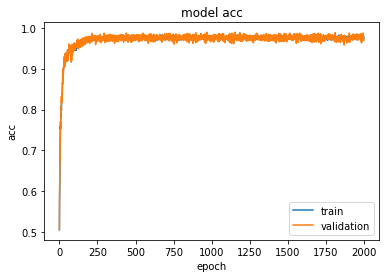

In [12]:
if(EXECUTION_MODE == "train"):
    
    history = unidirectional_model.fit_generator(
        batch_for_network_generator(),
        steps_per_epoch=BATCH_SIZE,
        validation_data=batch_for_network_generator(),
        validation_steps=BATCH_SIZE/4,
        epochs=EPOCH_SIZE,
        callbacks=callbacks_list
    )

    list_of_histories.append(history)

    plot_train(list_of_histories)
    
# BATCH_SIZE = 64
# PALINDROME_SIZE = 10
# NUM_OF_CHARS = 26
# PATIENCE = 50

# 1 x LSTM(256) - val_acc at 0.9990 after 94 epochs, peak val_acc at 0.9990 after 43 epochs

# 1 x LSTM(32) - val_acc at 0.9922 after 121 epochs, peak val_acc at 0.9971 after 70 epochs
# 1 x LSTM(32) - val_acc at 0.9941 after 201 epochs, peak val_acc at 0.9990 after 150 epochs
# 1 x LSTM(32) - val_acc at 0.9941 after 284 epochs, peak val_acc at 1.0000 after 233 epochs
# 1 x LSTM(32) - val_acc at 0.9932 after 384 epochs, peak val_acc at 1.0000 after 333 epochs
# 1 x LSTM(32) - val_acc at 0.9980 after 439 epochs, peak val_acc at 1.0000 after 388 epochs
# 1 x LSTM(32) - val_acc at 0.9980 after 000 epochs, peak val_acc at 0.9990 after 000 epochs

# 1 x LSTM(16) - val_acc at 0.9951 after 242 epochs, peak val_acc at 0.9990 after 191 epochs
# 1 x LSTM(16) - val_acc at 0.9961 after 334 epochs, peak val_acc at 1.0000 after 283 epochs

# 1 x LSTM(16) - val_acc at 0.9912 after 190 epochs, peak val_acc at 0.9922 after 139 epochs
# 1 x LSTM(16) - val_acc at 0.9912 after 262 epochs, peak val_acc at 0.9990 after 211 epochs
# 1 x LSTM(16) - val_acc at 0.9873 after 333 epochs, peak val_acc at 0.9961 after 282 epochs
# 1 x LSTM(16) - val_acc at 0.9873 after 483 epochs, peak val_acc at 0.9980 after 432 epochs
# 1 x LSTM(16) - val_acc at 0.9883 after 564 epochs, peak val_acc at 0.9961 after 211 epochs
# 1 x LSTM(16) - val_acc at 0.9883 after 622 epochs, peak val_acc at 0.9951 after 571 epochs

# 1 x LSTM(8) - val_acc at 0.9824 after 259 epochs, peak val_acc at 0.9863 after 208 epochs
# 1 x LSTM(8) - val_acc at 0.9746 after 321 epochs, peak val_acc at 0.9854 after 270 epochs
# 1 x LSTM(8) - val_acc at 0.9795 after 417 epochs, peak val_acc at 0.9863 after 366 epochs
# 1 x LSTM(8) - val_acc at 0.9775 after 496 epochs, peak val_acc at 0.9873 after 445 epochs
# 1 x LSTM(8) - val_acc at 0.9805 after 584 epochs, peak val_acc at 0.9883 after 533 epochs
# 1 x LSTM(8) - val_acc at 0.9785 after 662 epochs, peak val_acc at 0.9854 after 611 epochs
# 1 x LSTM(8) - val_acc at 0.9707 after 796 epochs, peak val_acc at 0.9893 after 745 epochs
# 1 x LSTM(8) - val_acc at 0.9795 after 926 epochs, peak val_acc at 0.9873 after 875 epochs
# 1 x LSTM(8) - val_acc at 0.9785 after 1018 epochs, peak val_acc at 0.9873 after 967 epochs

# 1 x LSTM(4) - val_acc at 0.9229 after 264 epochs, peak val_acc at 0.9443 after 213 epochs
# 1 x LSTM(4) - val_acc at 0.9258 after 347 epochs, peak val_acc at 0.9385 after 296 epochs
# 1 x LSTM(4) - val_acc at 0.9229 after 614 epochs, peak val_acc at 0.9414 after 563 epochs
# 1 x LSTM(4) - val_acc at 0.9326 after 678 epochs, peak val_acc at 0.9404 after 627 epochs
# 1 x LSTM(4) - val_acc at 0.9170 after 748 epochs, peak val_acc at 0.9443 after 697 epochs
# 1 x LSTM(4) - val_acc at 0.9326 after 840 epochs, peak val_acc at 0.9453 after 789 epochs
# 1 x LSTM(4) - val_acc at 0.9219 after 1042 epochs, peak val_acc at 0.9453 after 961 epochs
# 1 x LSTM(4) - val_acc at 0.9346 after 1136 epochs, peak val_acc at 0.9463 after 1085 epochs

# 1 x LSTM(2) - val_acc at 0.8281 after 208 epochs, peak val_acc at 0.8652 after 157 epochs
# 1 x LSTM(2) - val_acc at 0.8623 after 287 epochs, peak val_acc at 0.8701 after 236 epochs
# 1 x LSTM(2) - val_acc at 0.8389 after 367 epochs, peak val_acc at 0.8623 after 316 epochs
# 1 x LSTM(2) - val_acc at 0.8408 after 421 epochs, peak val_acc at 0.8730 after 370 epochs
# 1 x LSTM(2) - val_acc at 0.8252 after 482 epochs, peak val_acc at 0.8594 after 431 epochs
# 1 x LSTM(2) - val_acc at 0.8555 after 544 epochs, peak val_acc at 0.8643 after 493 epochs

In [38]:
filepath = "Palindrome-LSTM_unidirectional_%s.h5" % FILE_SUFFIX
if(EXECUTION_MODE == "train"):
    unidirectional_model.save(filepath)
elif(EXECUTION_MODE == "load_pretrained"):
    unidirectional_model = load_model(filepath)
    print("Model is loaded from a pretrained model")
    unidirectional_model.summary()

    
predict_with_model(unidirectional_model, batch_for_network_generator)

Model is loaded from a pretrained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1120      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,129
Trainable params: 1,129
Non-trainable params: 0
_________________________________________________________________
Predicted correctly: 97.17261904761905 %
Out of the wrongs, percentage of false positives: 94.73684210526316 %
Out of the wrongs, percentage of false negatives: 5.2631578947368425 %
Wrongs
['Test', 'Actual', 'Predicted']
[['gzmjqqowko' '0' '1']
 ['dreertqnyj' '0' '1']
 ['ekqkiemeev' '0' '1']
 ['ilnlnynwzi' '0' '1']
 ['pcuizfmdvn' '0' '1']
 ['ejweswfyrn' '0' '1']

# LSTM Bidirectional-Concat Model

In [31]:
if(EXECUTION_MODE == "train"):
    
    inp = Input(shape=(PALINDROME_SIZE, NUM_OF_CHARS))
    print('our input shape is ',(PALINDROME_SIZE, NUM_OF_CHARS) )
    x = Bidirectional( LSTM(4) , input_shape=(PALINDROME_SIZE, 1),  merge_mode='concat' )(inp)
#     x = Dropout(0.2)(x)  # Dropout is commented to remove randomness for better comparison
    output = Dense(1, activation ='sigmoid')(x)
    
    adam = Adam(lr=0.01)
    bidirectional_concat_model = Model(inputs = inp, outputs=output )
    bidirectional_concat_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    bidirectional_concat_model.summary()
    
    list_of_histories = []

our input shape is  (10, 26)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 8)                 992       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
64/64 [==============================] - 3s - loss: 0.6929 - acc: 0.5134 - val_loss: 0.6936 - val_acc: 0.5156
Epoch 2/2000
64/64 [==============================] - 2s - loss: 0.6847 - acc: 0.5496 - val_loss: 0.6693 - val_acc: 0.5938
Epoch 3/2000
64/64 [==============================] - 2s - loss: 0.6524 - acc: 0.6157 - val_loss: 0.6410 - val_acc: 0.6328
Epoch 4/2000
64/64 [==============================] - 2s - loss: 0.6022 - acc: 0.6724 - val_loss: 0.5782 - val_acc: 0.6875
Epoch 5/2000
64/64 [==============================] - 2s - loss: 0.5506 - acc: 0.7285 - val_loss: 0.5409 - val_acc: 0.73830
Epoch 6/2000
64/64 [==============================] - 2s - loss: 0.4882 - acc: 0.7827 - val_loss: 0.4493 - val_acc: 0.8164
Epoch 7/2000
64/64 [==============================] - 2s - loss: 0.4181 - acc: 0.8250 - val_loss: 0.3763 - val_acc: 0.8467
Epoch 8/2000
64/64 [==============================] - 2s - loss: 0.3821 - acc: 0.8447 - val_loss: 0.3727 - val_acc: 0.8594
Epoch 9/2000
64

64/64 [==============================] - 2s - loss: 0.3207 - acc: 0.8611 - val_loss: 0.3322 - val_acc: 0.8584
Epoch 68/2000
64/64 [==============================] - 2s - loss: 0.3181 - acc: 0.8625 - val_loss: 0.3005 - val_acc: 0.8906
Epoch 69/2000
64/64 [==============================] - 2s - loss: 0.3133 - acc: 0.8691 - val_loss: 0.3247 - val_acc: 0.8545
Epoch 70/2000
64/64 [==============================] - 2s - loss: 0.3051 - acc: 0.8679 - val_loss: 0.2904 - val_acc: 0.8730
Epoch 71/2000
64/64 [==============================] - 2s - loss: 0.3116 - acc: 0.8635 - val_loss: 0.2952 - val_acc: 0.8691
Epoch 72/2000
64/64 [==============================] - 2s - loss: 0.3128 - acc: 0.8608 - val_loss: 0.3167 - val_acc: 0.8564
Epoch 73/2000
64/64 [==============================] - 2s - loss: 0.3122 - acc: 0.8640 - val_loss: 0.2850 - val_acc: 0.8789
Epoch 74/2000
64/64 [==============================] - 2s - loss: 0.3146 - acc: 0.8604 - val_loss: 0.3256 - val_acc: 0.8477
Epoch 75/2000
64/64 [=

64/64 [==============================] - 2s - loss: 0.2988 - acc: 0.8718 - val_loss: 0.2953 - val_acc: 0.8730
Epoch 198/2000
64/64 [==============================] - 2s - loss: 0.2896 - acc: 0.8743 - val_loss: 0.2949 - val_acc: 0.8760
Epoch 199/2000
64/64 [==============================] - 2s - loss: 0.2968 - acc: 0.8723 - val_loss: 0.3126 - val_acc: 0.8633
Epoch 200/2000
64/64 [==============================] - 2s - loss: 0.2991 - acc: 0.8684 - val_loss: 0.2801 - val_acc: 0.8799
Epoch 201/2000
64/64 [==============================] - 2s - loss: 0.3116 - acc: 0.8604 - val_loss: 0.3053 - val_acc: 0.8633
Epoch 202/2000
64/64 [==============================] - 2s - loss: 0.3005 - acc: 0.8748 - val_loss: 0.3096 - val_acc: 0.8643
Epoch 203/2000
64/64 [==============================] - 2s - loss: 0.2899 - acc: 0.8777 - val_loss: 0.2928 - val_acc: 0.8750
Epoch 204/2000
64/64 [==============================] - 2s - loss: 0.2956 - acc: 0.8701 - val_loss: 0.3015 - val_acc: 0.8691
Epoch 205/2000


64/64 [==============================] - 2s - loss: 0.3032 - acc: 0.8694 - val_loss: 0.3054 - val_acc: 0.8770
Epoch 328/2000
64/64 [==============================] - 2s - loss: 0.2880 - acc: 0.8792 - val_loss: 0.3081 - val_acc: 0.8633
Epoch 329/2000
64/64 [==============================] - 2s - loss: 0.3128 - acc: 0.8601 - val_loss: 0.2926 - val_acc: 0.8701
Epoch 330/2000
64/64 [==============================] - 2s - loss: 0.2985 - acc: 0.8711 - val_loss: 0.2790 - val_acc: 0.8809
Epoch 331/2000
64/64 [==============================] - 2s - loss: 0.3000 - acc: 0.8694 - val_loss: 0.2740 - val_acc: 0.8828
Epoch 332/2000
64/64 [==============================] - 2s - loss: 0.3106 - acc: 0.8647 - val_loss: 0.2809 - val_acc: 0.8809
Epoch 333/2000
64/64 [==============================] - 2s - loss: 0.3041 - acc: 0.8672 - val_loss: 0.3009 - val_acc: 0.8721
Epoch 334/2000
64/64 [==============================] - 2s - loss: 0.2938 - acc: 0.8762 - val_loss: 0.2994 - val_acc: 0.8672
Epoch 335/2000


64/64 [==============================] - 2s - loss: 0.2959 - acc: 0.8762 - val_loss: 0.2850 - val_acc: 0.8730
Epoch 458/2000
64/64 [==============================] - 2s - loss: 0.3035 - acc: 0.8682 - val_loss: 0.2912 - val_acc: 0.8828
Epoch 459/2000
64/64 [==============================] - 2s - loss: 0.2951 - acc: 0.8728 - val_loss: 0.3025 - val_acc: 0.8633
Epoch 460/2000
64/64 [==============================] - 2s - loss: 0.3039 - acc: 0.8691 - val_loss: 0.2874 - val_acc: 0.8672
Epoch 461/2000
64/64 [==============================] - 2s - loss: 0.2968 - acc: 0.8740 - val_loss: 0.2997 - val_acc: 0.8740
Epoch 462/2000
64/64 [==============================] - 2s - loss: 0.2769 - acc: 0.8865 - val_loss: 0.3090 - val_acc: 0.8672
Epoch 463/2000
64/64 [==============================] - 2s - loss: 0.2981 - acc: 0.8689 - val_loss: 0.3261 - val_acc: 0.8486
Epoch 464/2000
64/64 [==============================] - 2s - loss: 0.3160 - acc: 0.8584 - val_loss: 0.2796 - val_acc: 0.8770
Epoch 465/2000


64/64 [==============================] - 2s - loss: 0.2997 - acc: 0.8694 - val_loss: 0.2873 - val_acc: 0.8818
Epoch 588/2000
64/64 [==============================] - 2s - loss: 0.2914 - acc: 0.8767 - val_loss: 0.2743 - val_acc: 0.8838
Epoch 589/2000
64/64 [==============================] - 2s - loss: 0.2966 - acc: 0.8657 - val_loss: 0.3001 - val_acc: 0.8779
Epoch 590/2000
64/64 [==============================] - 2s - loss: 0.2993 - acc: 0.8706 - val_loss: 0.2743 - val_acc: 0.8906
Epoch 591/2000
64/64 [==============================] - 2s - loss: 0.2877 - acc: 0.8748 - val_loss: 0.3097 - val_acc: 0.8662
Epoch 592/2000
64/64 [==============================] - 2s - loss: 0.2960 - acc: 0.8652 - val_loss: 0.3130 - val_acc: 0.8643
Epoch 593/2000
64/64 [==============================] - 2s - loss: 0.2974 - acc: 0.8687 - val_loss: 0.2929 - val_acc: 0.8545
Epoch 594/2000
64/64 [==============================] - 2s - loss: 0.3035 - acc: 0.8630 - val_loss: 0.2754 - val_acc: 0.8857
Epoch 595/2000


64/64 [==============================] - 2s - loss: 0.3006 - acc: 0.8694 - val_loss: 0.3103 - val_acc: 0.8613
Epoch 718/2000
64/64 [==============================] - 2s - loss: 0.2926 - acc: 0.8701 - val_loss: 0.3179 - val_acc: 0.8545
Epoch 719/2000
64/64 [==============================] - 2s - loss: 0.3042 - acc: 0.8679 - val_loss: 0.2898 - val_acc: 0.8740
Epoch 720/2000
64/64 [==============================] - 2s - loss: 0.3054 - acc: 0.8704 - val_loss: 0.2877 - val_acc: 0.8789
Epoch 721/2000
64/64 [==============================] - 2s - loss: 0.2908 - acc: 0.8704 - val_loss: 0.3009 - val_acc: 0.8711
Epoch 722/2000
64/64 [==============================] - 2s - loss: 0.3023 - acc: 0.8696 - val_loss: 0.3108 - val_acc: 0.8633
Epoch 723/2000
64/64 [==============================] - 2s - loss: 0.2972 - acc: 0.8728 - val_loss: 0.2786 - val_acc: 0.8789
Epoch 724/2000
64/64 [==============================] - 2s - loss: 0.3045 - acc: 0.8660 - val_loss: 0.2842 - val_acc: 0.8760
Epoch 725/2000


64/64 [==============================] - 2s - loss: 0.2897 - acc: 0.8784 - val_loss: 0.2975 - val_acc: 0.8682
Epoch 848/2000
64/64 [==============================] - 2s - loss: 0.3014 - acc: 0.8657 - val_loss: 0.3055 - val_acc: 0.8623
Epoch 849/2000
64/64 [==============================] - 2s - loss: 0.2909 - acc: 0.8733 - val_loss: 0.2891 - val_acc: 0.8779
Epoch 850/2000
64/64 [==============================] - 2s - loss: 0.2981 - acc: 0.8687 - val_loss: 0.2964 - val_acc: 0.8662
Epoch 851/2000
64/64 [==============================] - 2s - loss: 0.3094 - acc: 0.8599 - val_loss: 0.2962 - val_acc: 0.8711
Epoch 852/2000
64/64 [==============================] - 2s - loss: 0.3096 - acc: 0.8601 - val_loss: 0.2960 - val_acc: 0.8672
Epoch 853/2000
64/64 [==============================] - 2s - loss: 0.2909 - acc: 0.8777 - val_loss: 0.3031 - val_acc: 0.8779
Epoch 854/2000
64/64 [==============================] - 2s - loss: 0.3032 - acc: 0.8701 - val_loss: 0.2755 - val_acc: 0.8838
Epoch 855/2000


64/64 [==============================] - 2s - loss: 0.2911 - acc: 0.8755 - val_loss: 0.2919 - val_acc: 0.8701
Epoch 978/2000
64/64 [==============================] - 2s - loss: 0.3064 - acc: 0.8691 - val_loss: 0.3166 - val_acc: 0.8633
Epoch 979/2000
64/64 [==============================] - 2s - loss: 0.3010 - acc: 0.8708 - val_loss: 0.2770 - val_acc: 0.8887
Epoch 980/2000
64/64 [==============================] - 2s - loss: 0.2970 - acc: 0.8691 - val_loss: 0.2990 - val_acc: 0.8672
Epoch 981/2000
64/64 [==============================] - 2s - loss: 0.3041 - acc: 0.8689 - val_loss: 0.2969 - val_acc: 0.8740
Epoch 982/2000
64/64 [==============================] - 2s - loss: 0.2938 - acc: 0.8733 - val_loss: 0.2961 - val_acc: 0.8750
Epoch 983/2000
64/64 [==============================] - 2s - loss: 0.2996 - acc: 0.8699 - val_loss: 0.2815 - val_acc: 0.8760
Epoch 984/2000
64/64 [==============================] - 2s - loss: 0.2894 - acc: 0.8801 - val_loss: 0.2793 - val_acc: 0.8838
Epoch 985/2000


64/64 [==============================] - 2s - loss: 0.3084 - acc: 0.8589 - val_loss: 0.2768 - val_acc: 0.8838
Epoch 1107/2000
64/64 [==============================] - 2s - loss: 0.2998 - acc: 0.8645 - val_loss: 0.2896 - val_acc: 0.8799
Epoch 1108/2000
64/64 [==============================] - 2s - loss: 0.2895 - acc: 0.8806 - val_loss: 0.2815 - val_acc: 0.8867
Epoch 1109/2000
64/64 [==============================] - 2s - loss: 0.2976 - acc: 0.8716 - val_loss: 0.3261 - val_acc: 0.8584
Epoch 1110/2000
64/64 [==============================] - 2s - loss: 0.3008 - acc: 0.8718 - val_loss: 0.3111 - val_acc: 0.8564
Epoch 1111/2000
64/64 [==============================] - 2s - loss: 0.2952 - acc: 0.8723 - val_loss: 0.2883 - val_acc: 0.8730
Epoch 1112/2000
64/64 [==============================] - 2s - loss: 0.3059 - acc: 0.8665 - val_loss: 0.2882 - val_acc: 0.8809
Epoch 1113/2000
64/64 [==============================] - 2s - loss: 0.3221 - acc: 0.8586 - val_loss: 0.2844 - val_acc: 0.8779
Epoch 11

64/64 [==============================] - 2s - loss: 0.3110 - acc: 0.8645 - val_loss: 0.2864 - val_acc: 0.8848
Epoch 1237/2000
64/64 [==============================] - 2s - loss: 0.3053 - acc: 0.8721 - val_loss: 0.2956 - val_acc: 0.8691
Epoch 1238/2000
64/64 [==============================] - 2s - loss: 0.2912 - acc: 0.8772 - val_loss: 0.2786 - val_acc: 0.8828
Epoch 1239/2000
64/64 [==============================] - 2s - loss: 0.2955 - acc: 0.8743 - val_loss: 0.2965 - val_acc: 0.8643
Epoch 1240/2000
64/64 [==============================] - 2s - loss: 0.3026 - acc: 0.8682 - val_loss: 0.2929 - val_acc: 0.8701
Epoch 1241/2000
64/64 [==============================] - 2s - loss: 0.2904 - acc: 0.8728 - val_loss: 0.2950 - val_acc: 0.8789
Epoch 1242/2000
64/64 [==============================] - 2s - loss: 0.2926 - acc: 0.8770 - val_loss: 0.3010 - val_acc: 0.8662
Epoch 1243/2000
64/64 [==============================] - 2s - loss: 0.2890 - acc: 0.8745 - val_loss: 0.3056 - val_acc: 0.8564
Epoch 12

64/64 [==============================] - 2s - loss: 0.3003 - acc: 0.8689 - val_loss: 0.3111 - val_acc: 0.8672: 0s - loss: 0.2990 - 
Epoch 1366/2000
64/64 [==============================] - 2s - loss: 0.2931 - acc: 0.8738 - val_loss: 0.3065 - val_acc: 0.8691
Epoch 1367/2000
64/64 [==============================] - 2s - loss: 0.3009 - acc: 0.8696 - val_loss: 0.3207 - val_acc: 0.8584
Epoch 1368/2000
64/64 [==============================] - 2s - loss: 0.2827 - acc: 0.8845 - val_loss: 0.3229 - val_acc: 0.8506
Epoch 1369/2000
64/64 [==============================] - 2s - loss: 0.2993 - acc: 0.8713 - val_loss: 0.3115 - val_acc: 0.8701
Epoch 1370/2000
64/64 [==============================] - 2s - loss: 0.2867 - acc: 0.8757 - val_loss: 0.2752 - val_acc: 0.8916
Epoch 1371/2000
64/64 [==============================] - 2s - loss: 0.3001 - acc: 0.8718 - val_loss: 0.2846 - val_acc: 0.8730
Epoch 1372/2000
64/64 [==============================] - 2s - loss: 0.2976 - acc: 0.8704 - val_loss: 0.2878 - va

64/64 [==============================] - 2s - loss: 0.2976 - acc: 0.8689 - val_loss: 0.3099 - val_acc: 0.8604
Epoch 1495/2000
64/64 [==============================] - 2s - loss: 0.2991 - acc: 0.8655 - val_loss: 0.2803 - val_acc: 0.8760
Epoch 1496/2000
64/64 [==============================] - 2s - loss: 0.3007 - acc: 0.8694 - val_loss: 0.2887 - val_acc: 0.8711
Epoch 1497/2000
64/64 [==============================] - 2s - loss: 0.3021 - acc: 0.8682 - val_loss: 0.3100 - val_acc: 0.8584
Epoch 1498/2000
64/64 [==============================] - 2s - loss: 0.2835 - acc: 0.8772 - val_loss: 0.3133 - val_acc: 0.8682
Epoch 1499/2000
64/64 [==============================] - 2s - loss: 0.2937 - acc: 0.8689 - val_loss: 0.2882 - val_acc: 0.8740
Epoch 1500/2000
64/64 [==============================] - 2s - loss: 0.2967 - acc: 0.8733 - val_loss: 0.2840 - val_acc: 0.8828
Epoch 1501/2000
64/64 [==============================] - 2s - loss: 0.3040 - acc: 0.8694 - val_loss: 0.2742 - val_acc: 0.8877
Epoch 15

64/64 [==============================] - 2s - loss: 0.3089 - acc: 0.8652 - val_loss: 0.2916 - val_acc: 0.8672
Epoch 1560/2000
64/64 [==============================] - 2s - loss: 0.2997 - acc: 0.8713 - val_loss: 0.3010 - val_acc: 0.8691
Epoch 1561/2000
64/64 [==============================] - 2s - loss: 0.2877 - acc: 0.8718 - val_loss: 0.2799 - val_acc: 0.8848
Epoch 1562/2000
64/64 [==============================] - 2s - loss: 0.3007 - acc: 0.8718 - val_loss: 0.2845 - val_acc: 0.8789
Epoch 1563/2000
64/64 [==============================] - 2s - loss: 0.3029 - acc: 0.8694 - val_loss: 0.2758 - val_acc: 0.8857
Epoch 1564/2000
64/64 [==============================] - 2s - loss: 0.2950 - acc: 0.8716 - val_loss: 0.3040 - val_acc: 0.8652
Epoch 1565/2000
64/64 [==============================] - 2s - loss: 0.3013 - acc: 0.8708 - val_loss: 0.2970 - val_acc: 0.86230.
Epoch 1566/2000
64/64 [==============================] - 2s - loss: 0.3000 - acc: 0.8687 - val_loss: 0.3064 - val_acc: 0.8730
Epoch 

64/64 [==============================] - 2s - loss: 0.3027 - acc: 0.8694 - val_loss: 0.2955 - val_acc: 0.8691
Epoch 1625/2000
64/64 [==============================] - 2s - loss: 0.2961 - acc: 0.8757 - val_loss: 0.2771 - val_acc: 0.8838
Epoch 1626/2000
64/64 [==============================] - 2s - loss: 0.2983 - acc: 0.8694 - val_loss: 0.3039 - val_acc: 0.8721
Epoch 1627/2000
64/64 [==============================] - 2s - loss: 0.3036 - acc: 0.8691 - val_loss: 0.2914 - val_acc: 0.8770
Epoch 1628/2000
64/64 [==============================] - 2s - loss: 0.2968 - acc: 0.8745 - val_loss: 0.2839 - val_acc: 0.8877
Epoch 1629/2000
64/64 [==============================] - 2s - loss: 0.2969 - acc: 0.8726 - val_loss: 0.2989 - val_acc: 0.8672
Epoch 1630/2000
64/64 [==============================] - 2s - loss: 0.2987 - acc: 0.8716 - val_loss: 0.3050 - val_acc: 0.8682
Epoch 1631/2000
64/64 [==============================] - 2s - loss: 0.3081 - acc: 0.8625 - val_loss: 0.2679 - val_acc: 0.8936
Epoch 16

64/64 [==============================] - 2s - loss: 0.2993 - acc: 0.8684 - val_loss: 0.2922 - val_acc: 0.8662
Epoch 1755/2000
64/64 [==============================] - 2s - loss: 0.3061 - acc: 0.8655 - val_loss: 0.2798 - val_acc: 0.8838loss: 0.3014 - acc: 0
Epoch 1756/2000
64/64 [==============================] - 2s - loss: 0.2957 - acc: 0.8770 - val_loss: 0.2850 - val_acc: 0.8740
Epoch 1757/2000
64/64 [==============================] - 2s - loss: 0.2965 - acc: 0.8733 - val_loss: 0.3020 - val_acc: 0.8633
Epoch 1758/2000
64/64 [==============================] - 2s - loss: 0.2972 - acc: 0.8691 - val_loss: 0.2677 - val_acc: 0.8848
Epoch 1759/2000
64/64 [==============================] - 2s - loss: 0.2975 - acc: 0.8655 - val_loss: 0.2727 - val_acc: 0.8916
Epoch 1760/2000
64/64 [==============================] - 2s - loss: 0.2951 - acc: 0.8735 - val_loss: 0.2998 - val_acc: 0.8701
Epoch 1761/2000
64/64 [==============================] - 2s - loss: 0.2989 - acc: 0.8716 - val_loss: 0.2957 - val

64/64 [==============================] - 2s - loss: 0.2986 - acc: 0.8730 - val_loss: 0.2722 - val_acc: 0.8848
Epoch 1883/2000
64/64 [==============================] - 2s - loss: 0.2889 - acc: 0.8733 - val_loss: 0.2747 - val_acc: 0.8799
Epoch 1884/2000
64/64 [==============================] - 2s - loss: 0.3034 - acc: 0.8718 - val_loss: 0.2754 - val_acc: 0.8799
Epoch 1885/2000
64/64 [==============================] - 2s - loss: 0.3078 - acc: 0.8630 - val_loss: 0.3282 - val_acc: 0.8428
Epoch 1886/2000
64/64 [==============================] - 2s - loss: 0.2970 - acc: 0.8716 - val_loss: 0.2843 - val_acc: 0.8779
Epoch 1887/2000
64/64 [==============================] - 2s - loss: 0.2906 - acc: 0.8743 - val_loss: 0.2890 - val_acc: 0.8838
Epoch 1888/2000
64/64 [==============================] - 2s - loss: 0.3118 - acc: 0.8625 - val_loss: 0.3018 - val_acc: 0.8711
Epoch 1889/2000
64/64 [==============================] - 2s - loss: 0.2944 - acc: 0.8750 - val_loss: 0.3119 - val_acc: 0.85940.8
Epoch

64/64 [==============================] - 2s - loss: 0.2930 - acc: 0.8728 - val_loss: 0.3009 - val_acc: 0.8662
Epoch 1948/2000
64/64 [==============================] - 2s - loss: 0.3035 - acc: 0.8652 - val_loss: 0.3137 - val_acc: 0.8604
Epoch 1949/2000
64/64 [==============================] - 2s - loss: 0.2849 - acc: 0.8811 - val_loss: 0.2865 - val_acc: 0.8818
Epoch 1950/2000
64/64 [==============================] - 2s - loss: 0.2934 - acc: 0.8704 - val_loss: 0.3129 - val_acc: 0.8574
Epoch 1951/2000
64/64 [==============================] - 2s - loss: 0.3023 - acc: 0.8716 - val_loss: 0.3092 - val_acc: 0.8574
Epoch 1952/2000
64/64 [==============================] - 2s - loss: 0.2907 - acc: 0.8752 - val_loss: 0.3158 - val_acc: 0.8525
Epoch 1953/2000
64/64 [==============================] - 2s - loss: 0.2996 - acc: 0.8713 - val_loss: 0.3031 - val_acc: 0.8652
Epoch 1954/2000
64/64 [==============================] - 2s - loss: 0.2967 - acc: 0.8723 - val_loss: 0.3172 - val_acc: 0.8613
Epoch 19

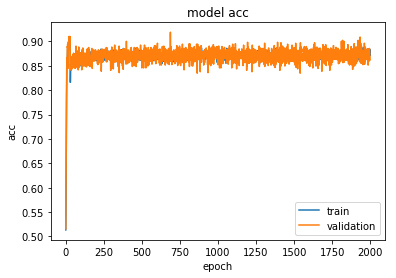

In [15]:
if(EXECUTION_MODE == "train"):

    history = bidirectional_concat_model.fit_generator(
        batch_for_network_generator(),
        steps_per_epoch=BATCH_SIZE,
        validation_data=batch_for_network_generator(),
        validation_steps=BATCH_SIZE/4,
        epochs=EPOCH_SIZE,
        callbacks=callbacks_list
    )

    list_of_histories.append(history)

    plot_train(list_of_histories)

# BATCH_SIZE = 64
# PALINDROME_SIZE = 10
# NUM_OF_CHARS = 26
# PATIENCE = 50

# 1 x Bidirectional(LSTM(16), "concat") - val_acc at 0.9961 after 116 epochs, peak val_acc at 0.9990 after 65 epochs
# 1 x Bidirectional(LSTM(16), "concat") - val_acc at 0.9980 after 184 epochs, peak val_acc at 1.0000 after 133 epochs

# 1 x Bidirectional(LSTM(8), "concat") - val_acc at 0.9775 after 131 epochs, peak val_acc at 0.9912 after 80 epochs
# 1 x Bidirectional(LSTM(8), "concat") - val_acc at 0.9746 after 186 epochs, peak val_acc at 0.9873 after 135 epochs
# 1 x Bidirectional(LSTM(8), "concat") - val_acc at 0.9805 after 308 epochs, peak val_acc at 0.9922 after 257 epochs
# 1 x Bidirectional(LSTM(8), "concat") - val_acc at 0.9785 after 360 epochs, peak val_acc at 0.9893 after 309 epochs
# 1 x Bidirectional(LSTM(8), "concat") - val_acc at 0.9824 after 424 epochs, peak val_acc at 0.9893 after 373 epochs

# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9932 after 131 epochs, peak val_acc at 0.9932 after 80 epochs
# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9863 after 203 epochs, peak val_acc at 0.9971 after 152 epochs
# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9932 after 271 epochs, peak val_acc at 0.9971 after 220 epochs
# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9922 after 351 epochs, peak val_acc at 0.9971 after 300 epochs
# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9873 after 408 epochs, peak val_acc at 0.9990 after 357 epochs
# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9951 after 472 epochs, peak val_acc at 0.9961 after 421 epochs
# 1 x Bidirectional(LSTM(4), "concat") - val_acc at 0.9893 after 560 epochs, peak val_acc at 0.9971 after 509 epochs

# 1 x Bidirectional(LSTM(2), "concat") - val_acc at 0.9316 after 253 epochs, peak val_acc at 0.9492 after 202 epochs
# 1 x Bidirectional(LSTM(2), "concat") - val_acc at 0.9258 after 330 epochs, peak val_acc at 0.9492 after 279 epochs
# 1 x Bidirectional(LSTM(2), "concat") - val_acc at 0.9277 after 413 epochs, peak val_acc at 0.9512 after 362 epochs
# 1 x Bidirectional(LSTM(2), "concat") - val_acc at 0.9316 after 480 epochs, peak val_acc at 0.9463 after 429 epochs
# 1 x Bidirectional(LSTM(2), "concat") - val_acc at 0.9326 after 542 epochs, peak val_acc at 0.9463 after 491 epochs

# This round of training seems to be an anomaly
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.7197 after 159 epochs, peak val_acc at 0.7871 after 108 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.7627 after 243 epochs, peak val_acc at 0.7920 after 192 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.7480 after 310 epochs, peak val_acc at 0.7920 after 259 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.7607 after 379 epochs, peak val_acc at 0.7910 after 328 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.7549 after 443 epochs, peak val_acc at 0.7832 after 392 epochs

# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8633 after 76 epochs, peak val_acc at 0.9062 after 25 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8779 after 137 epochs, peak val_acc at 0.9072 after 86 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8926 after 201 epochs, peak val_acc at 0.9072 after 150 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8799 after 263 epochs, peak val_acc at 0.9043 after 212 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8818 after 400 epochs, peak val_acc at 0.9053 after 349 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8818 after 460 epochs, peak val_acc at 0.9150 after 409 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8857 after 551 epochs, peak val_acc at 0.9160 after 500 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8848 after 610 epochs, peak val_acc at 0.9121 after 559 epochs
# 1 x Bidirectional(LSTM(1), "concat") - val_acc at 0.8906 after 686 epochs, peak val_acc at 0.9092 after 635 epochs

In [39]:
filepath = "Palindrome-LSTM_bidirectional_concat_%s.h5" % FILE_SUFFIX
if(EXECUTION_MODE == "train"):
    bidirectional_concat_model.save(filepath)
elif(EXECUTION_MODE == "load_pretrained"):
    bidirectional_concat_model = load_model(filepath)
    print("Model is loaded from a pretrained model")
    bidirectional_concat_model.summary()
    
predict_with_model(bidirectional_concat_model, batch_for_network_generator)

Model is loaded from a pretrained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8)                 992       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Predicted correctly: 87.20238095238095 %
Out of the wrongs, percentage of false positives: 99.4186046511628 %
Out of the wrongs, percentage of false negatives: 0.5813953488372093 %
Wrongs
['Test', 'Actual', 'Predicted']
[['vfuwseooym' '0' '1']
 ['jvqxcdekot' '0' '1']
 ['gxugsbiood' '0' '1']
 ['caokcrmkma' '0' '1']
 ['ormbewlsnc' '0' '1']
 ['xufvxkbddm' '0' '1']


# LSTM Bidirectional-Average Model

In [17]:
if(EXECUTION_MODE == "train"):
    
    inp = Input(shape=(PALINDROME_SIZE, NUM_OF_CHARS))
    print('our input shape is ',(PALINDROME_SIZE, NUM_OF_CHARS) )
    x = Bidirectional( LSTM(4) , input_shape=(PALINDROME_SIZE, 1),  merge_mode='ave' )(inp)
#     x = Dropout(0.2)(x)  # Dropout is commented to remove randomness for better comparison
    output = Dense(1, activation ='sigmoid')(x)
    
    adam = Adam(lr=0.01)
    bidirectional_ave_model = Model(inputs = inp, outputs=output )
    bidirectional_ave_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    bidirectional_ave_model.summary()
    
    list_of_histories = []

our input shape is  (10, 26)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 4)                 992       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 997
Trainable params: 997
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
64/64 [==============================] - 3s - loss: 0.6941 - acc: 0.5078 - val_loss: 0.6904 - val_acc: 0.5449
Epoch 2/2000
64/64 [==============================] - 2s - loss: 0.6834 - acc: 0.5667 - val_loss: 0.6788 - val_acc: 0.5791
Epoch 3/2000
64/64 [==============================] - 2s - loss: 0.6614 - acc: 0.6033 - val_loss: 0.6373 - val_acc: 0.6289
Epoch 4/2000
64/64 [==============================] - 2s - loss: 0.6178 - acc: 0.6655 - val_loss: 0.5860 - val_acc: 0.6982
Epoch 5/2000
64/64 [==============================] - 2s - loss: 0.5619 - acc: 0.7095 - val_loss: 0.5246 - val_acc: 0.7373
Epoch 6/2000
64/64 [==============================] - 2s - loss: 0.4847 - acc: 0.7607 - val_loss: 0.4538 - val_acc: 0.7764
Epoch 7/2000
64/64 [==============================] - 2s - loss: 0.4425 - acc: 0.7983 - val_loss: 0.4105 - val_acc: 0.8301
Epoch 8/2000
64/64 [==============================] - 2s - loss: 0.3832 - acc: 0.8394 - val_loss: 0.3460 - val_acc: 0.8516
Epoch 9/2000
64/

64/64 [==============================] - 2s - loss: 0.0996 - acc: 0.9697 - val_loss: 0.1191 - val_acc: 0.9648
Epoch 133/2000
64/64 [==============================] - 2s - loss: 0.1048 - acc: 0.9705 - val_loss: 0.1215 - val_acc: 0.9609
Epoch 134/2000
64/64 [==============================] - 2s - loss: 0.0999 - acc: 0.9717 - val_loss: 0.1108 - val_acc: 0.9658
Epoch 135/2000
64/64 [==============================] - 2s - loss: 0.0978 - acc: 0.9727 - val_loss: 0.0856 - val_acc: 0.9766
Epoch 136/2000
64/64 [==============================] - 2s - loss: 0.0918 - acc: 0.9727 - val_loss: 0.0765 - val_acc: 0.9795
Epoch 137/2000
64/64 [==============================] - 2s - loss: 0.1006 - acc: 0.9690 - val_loss: 0.0934 - val_acc: 0.9717
Epoch 138/2000
64/64 [==============================] - 2s - loss: 0.1006 - acc: 0.9705 - val_loss: 0.0929 - val_acc: 0.9756
Epoch 139/2000
64/64 [==============================] - 2s - loss: 0.0924 - acc: 0.9736 - val_loss: 0.0969 - val_acc: 0.9707
Epoch 140/2000


64/64 [==============================] - 2s - loss: 0.0918 - acc: 0.9734 - val_loss: 0.0912 - val_acc: 0.9775
Epoch 263/2000
64/64 [==============================] - 2s - loss: 0.0778 - acc: 0.9805 - val_loss: 0.0850 - val_acc: 0.9746
Epoch 264/2000
64/64 [==============================] - 2s - loss: 0.1008 - acc: 0.9709 - val_loss: 0.0791 - val_acc: 0.9727
Epoch 265/2000
64/64 [==============================] - 2s - loss: 0.0838 - acc: 0.9763 - val_loss: 0.0549 - val_acc: 0.9873
Epoch 266/2000
64/64 [==============================] - 2s - loss: 0.0751 - acc: 0.9795 - val_loss: 0.0756 - val_acc: 0.9766
Epoch 267/2000
64/64 [==============================] - 2s - loss: 0.0868 - acc: 0.9771 - val_loss: 0.1106 - val_acc: 0.9668
Epoch 268/2000
64/64 [==============================] - 2s - loss: 0.0797 - acc: 0.9802 - val_loss: 0.0698 - val_acc: 0.9824
Epoch 269/2000
64/64 [==============================] - 2s - loss: 0.0829 - acc: 0.9788 - val_loss: 0.0987 - val_acc: 0.9736
Epoch 270/2000


64/64 [==============================] - 2s - loss: 0.0924 - acc: 0.9741 - val_loss: 0.0675 - val_acc: 0.9863
Epoch 393/2000
64/64 [==============================] - 2s - loss: 0.0904 - acc: 0.9749 - val_loss: 0.0820 - val_acc: 0.9795
Epoch 394/2000
64/64 [==============================] - 2s - loss: 0.0801 - acc: 0.9773 - val_loss: 0.0664 - val_acc: 0.9844
Epoch 395/2000
64/64 [==============================] - 2s - loss: 0.0813 - acc: 0.9792 - val_loss: 0.0779 - val_acc: 0.9785
Epoch 396/2000
64/64 [==============================] - 2s - loss: 0.0947 - acc: 0.9729 - val_loss: 0.0741 - val_acc: 0.9834
Epoch 397/2000
64/64 [==============================] - 2s - loss: 0.0840 - acc: 0.9780 - val_loss: 0.0750 - val_acc: 0.9805
Epoch 398/2000
64/64 [==============================] - 2s - loss: 0.0864 - acc: 0.9768 - val_loss: 0.0734 - val_acc: 0.9775
Epoch 399/2000
64/64 [==============================] - 2s - loss: 0.0887 - acc: 0.9741 - val_loss: 0.0989 - val_acc: 0.9727
Epoch 400/2000


64/64 [==============================] - 2s - loss: 0.0971 - acc: 0.9744 - val_loss: 0.0706 - val_acc: 0.9814
Epoch 523/2000
64/64 [==============================] - 2s - loss: 0.0726 - acc: 0.9824 - val_loss: 0.0667 - val_acc: 0.9834
Epoch 524/2000
64/64 [==============================] - 2s - loss: 0.0846 - acc: 0.9778 - val_loss: 0.0790 - val_acc: 0.9795
Epoch 525/2000
64/64 [==============================] - 2s - loss: 0.0828 - acc: 0.9768 - val_loss: 0.1018 - val_acc: 0.9766
Epoch 526/2000
64/64 [==============================] - 2s - loss: 0.0828 - acc: 0.9758 - val_loss: 0.0711 - val_acc: 0.9844
Epoch 527/2000
64/64 [==============================] - 2s - loss: 0.0758 - acc: 0.9802 - val_loss: 0.0791 - val_acc: 0.9795
Epoch 528/2000
64/64 [==============================] - 2s - loss: 0.0822 - acc: 0.9771 - val_loss: 0.0884 - val_acc: 0.9775
Epoch 529/2000
64/64 [==============================] - 2s - loss: 0.0847 - acc: 0.9780 - val_loss: 0.0732 - val_acc: 0.9805
Epoch 530/2000


64/64 [==============================] - 2s - loss: 0.0838 - acc: 0.9768 - val_loss: 0.0946 - val_acc: 0.9707
Epoch 653/2000
64/64 [==============================] - 2s - loss: 0.0867 - acc: 0.9744 - val_loss: 0.0864 - val_acc: 0.9756
Epoch 654/2000
64/64 [==============================] - 2s - loss: 0.0827 - acc: 0.9778 - val_loss: 0.0892 - val_acc: 0.9775
Epoch 655/2000
64/64 [==============================] - 2s - loss: 0.0933 - acc: 0.9727 - val_loss: 0.0977 - val_acc: 0.9688
Epoch 656/2000
64/64 [==============================] - 2s - loss: 0.0945 - acc: 0.9719 - val_loss: 0.0775 - val_acc: 0.9727
Epoch 657/2000
64/64 [==============================] - 2s - loss: 0.0749 - acc: 0.9795 - val_loss: 0.0838 - val_acc: 0.9795
Epoch 658/2000
64/64 [==============================] - 2s - loss: 0.0886 - acc: 0.9766 - val_loss: 0.0834 - val_acc: 0.9766
Epoch 659/2000
64/64 [==============================] - 2s - loss: 0.0918 - acc: 0.9746 - val_loss: 0.1034 - val_acc: 0.9688
Epoch 660/2000


64/64 [==============================] - 2s - loss: 0.0880 - acc: 0.9773 - val_loss: 0.0731 - val_acc: 0.9805
Epoch 783/2000
64/64 [==============================] - 2s - loss: 0.0819 - acc: 0.9788 - val_loss: 0.0928 - val_acc: 0.9766
Epoch 784/2000
64/64 [==============================] - 2s - loss: 0.0887 - acc: 0.9753 - val_loss: 0.0770 - val_acc: 0.9814
Epoch 785/2000
64/64 [==============================] - 2s - loss: 0.0853 - acc: 0.9771 - val_loss: 0.0809 - val_acc: 0.9746
Epoch 786/2000
64/64 [==============================] - 2s - loss: 0.0843 - acc: 0.9768 - val_loss: 0.0825 - val_acc: 0.9795
Epoch 787/2000
64/64 [==============================] - 2s - loss: 0.0834 - acc: 0.9751 - val_loss: 0.0827 - val_acc: 0.9756
Epoch 788/2000
64/64 [==============================] - 2s - loss: 0.0815 - acc: 0.9758 - val_loss: 0.1004 - val_acc: 0.9707
Epoch 789/2000
64/64 [==============================] - 2s - loss: 0.0697 - acc: 0.9822 - val_loss: 0.0635 - val_acc: 0.9863
Epoch 790/2000


64/64 [==============================] - 2s - loss: 0.0769 - acc: 0.9802 - val_loss: 0.0780 - val_acc: 0.9756
Epoch 913/2000
64/64 [==============================] - 2s - loss: 0.0850 - acc: 0.9775 - val_loss: 0.0732 - val_acc: 0.9805
Epoch 914/2000
64/64 [==============================] - 2s - loss: 0.0766 - acc: 0.9778 - val_loss: 0.0958 - val_acc: 0.9746
Epoch 915/2000
64/64 [==============================] - 2s - loss: 0.0858 - acc: 0.9761 - val_loss: 0.0640 - val_acc: 0.9824
Epoch 916/2000
64/64 [==============================] - 2s - loss: 0.0804 - acc: 0.9780 - val_loss: 0.0859 - val_acc: 0.9736
Epoch 917/2000
64/64 [==============================] - 2s - loss: 0.0927 - acc: 0.9717 - val_loss: 0.0960 - val_acc: 0.9766
Epoch 918/2000
64/64 [==============================] - 2s - loss: 0.0730 - acc: 0.9810 - val_loss: 0.0976 - val_acc: 0.9746
Epoch 919/2000
64/64 [==============================] - 2s - loss: 0.0829 - acc: 0.9768 - val_loss: 0.0823 - val_acc: 0.9766
Epoch 920/2000


64/64 [==============================] - 2s - loss: 0.0772 - acc: 0.9802 - val_loss: 0.0882 - val_acc: 0.9766
Epoch 1043/2000
64/64 [==============================] - 2s - loss: 0.0837 - acc: 0.9763 - val_loss: 0.0807 - val_acc: 0.9814
Epoch 1044/2000
64/64 [==============================] - 2s - loss: 0.0826 - acc: 0.9768 - val_loss: 0.0884 - val_acc: 0.9736
Epoch 1045/2000
64/64 [==============================] - 2s - loss: 0.0740 - acc: 0.9812 - val_loss: 0.0831 - val_acc: 0.9736
Epoch 1046/2000
64/64 [==============================] - 2s - loss: 0.0806 - acc: 0.9780 - val_loss: 0.1178 - val_acc: 0.9648
Epoch 1047/2000
64/64 [==============================] - 2s - loss: 0.0929 - acc: 0.9736 - val_loss: 0.0704 - val_acc: 0.9805
Epoch 1048/2000
64/64 [==============================] - 2s - loss: 0.0869 - acc: 0.9761 - val_loss: 0.0803 - val_acc: 0.9775
Epoch 1049/2000
64/64 [==============================] - 2s - loss: 0.0852 - acc: 0.9753 - val_loss: 0.0963 - val_acc: 0.9736
Epoch 10

64/64 [==============================] - 2s - loss: 0.0905 - acc: 0.9751 - val_loss: 0.0758 - val_acc: 0.9844
Epoch 1173/2000
64/64 [==============================] - 2s - loss: 0.0953 - acc: 0.9736 - val_loss: 0.0751 - val_acc: 0.9824
Epoch 1174/2000
64/64 [==============================] - 2s - loss: 0.0830 - acc: 0.9788 - val_loss: 0.0848 - val_acc: 0.9805
Epoch 1175/2000
64/64 [==============================] - 2s - loss: 0.0768 - acc: 0.9790 - val_loss: 0.0908 - val_acc: 0.9717
Epoch 1176/2000
64/64 [==============================] - 2s - loss: 0.0803 - acc: 0.9792 - val_loss: 0.0605 - val_acc: 0.9863
Epoch 1177/2000
64/64 [==============================] - 2s - loss: 0.0809 - acc: 0.9771 - val_loss: 0.0948 - val_acc: 0.9707
Epoch 1178/2000
64/64 [==============================] - 2s - loss: 0.0823 - acc: 0.9761 - val_loss: 0.0702 - val_acc: 0.9834
Epoch 1179/2000
64/64 [==============================] - 2s - loss: 0.0930 - acc: 0.9758 - val_loss: 0.0816 - val_acc: 0.9805
Epoch 11

64/64 [==============================] - 2s - loss: 0.0782 - acc: 0.9788 - val_loss: 0.0773 - val_acc: 0.98140.9
Epoch 1303/2000
64/64 [==============================] - 2s - loss: 0.0871 - acc: 0.9768 - val_loss: 0.0830 - val_acc: 0.9785
Epoch 1304/2000
64/64 [==============================] - 2s - loss: 0.0730 - acc: 0.9822 - val_loss: 0.0834 - val_acc: 0.9766
Epoch 1305/2000
64/64 [==============================] - 2s - loss: 0.0922 - acc: 0.9749 - val_loss: 0.0752 - val_acc: 0.9785
Epoch 1306/2000
64/64 [==============================] - 2s - loss: 0.0925 - acc: 0.9741 - val_loss: 0.0730 - val_acc: 0.9805
Epoch 1307/2000
64/64 [==============================] - 2s - loss: 0.0758 - acc: 0.9817 - val_loss: 0.0894 - val_acc: 0.9775
Epoch 1308/2000
64/64 [==============================] - 2s - loss: 0.0862 - acc: 0.9749 - val_loss: 0.0743 - val_acc: 0.9756
Epoch 1309/2000
64/64 [==============================] - 2s - loss: 0.0806 - acc: 0.9771 - val_loss: 0.0710 - val_acc: 0.9824
Epoch

64/64 [==============================] - 2s - loss: 0.0992 - acc: 0.9727 - val_loss: 0.0921 - val_acc: 0.9697
Epoch 1368/2000
64/64 [==============================] - 2s - loss: 0.0890 - acc: 0.9768 - val_loss: 0.1058 - val_acc: 0.9707
Epoch 1369/2000
64/64 [==============================] - 2s - loss: 0.0809 - acc: 0.9758 - val_loss: 0.0918 - val_acc: 0.9727
Epoch 1370/2000
64/64 [==============================] - 2s - loss: 0.0885 - acc: 0.9753 - val_loss: 0.0597 - val_acc: 0.9844
Epoch 1371/2000
64/64 [==============================] - 2s - loss: 0.0862 - acc: 0.9744 - val_loss: 0.0546 - val_acc: 0.9883
Epoch 1372/2000
64/64 [==============================] - 2s - loss: 0.0759 - acc: 0.9805 - val_loss: 0.0721 - val_acc: 0.9824
Epoch 1373/2000
64/64 [==============================] - 2s - loss: 0.0848 - acc: 0.9766 - val_loss: 0.0932 - val_acc: 0.9766
Epoch 1374/2000
64/64 [==============================] - 2s - loss: 0.0841 - acc: 0.9749 - val_loss: 0.1026 - val_acc: 0.9727
Epoch 13

64/64 [==============================] - 2s - loss: 0.0825 - acc: 0.9780 - val_loss: 0.0702 - val_acc: 0.9824
Epoch 1498/2000
64/64 [==============================] - 2s - loss: 0.0908 - acc: 0.9741 - val_loss: 0.0987 - val_acc: 0.9746
Epoch 1499/2000
64/64 [==============================] - 2s - loss: 0.0790 - acc: 0.9797 - val_loss: 0.0760 - val_acc: 0.9795
Epoch 1500/2000
64/64 [==============================] - 2s - loss: 0.0857 - acc: 0.9768 - val_loss: 0.0993 - val_acc: 0.9727
Epoch 1501/2000
64/64 [==============================] - 2s - loss: 0.0904 - acc: 0.9736 - val_loss: 0.1099 - val_acc: 0.9678
Epoch 1502/2000
64/64 [==============================] - 2s - loss: 0.0830 - acc: 0.9756 - val_loss: 0.0781 - val_acc: 0.9795
Epoch 1503/2000
64/64 [==============================] - 2s - loss: 0.0822 - acc: 0.9792 - val_loss: 0.1035 - val_acc: 0.9688
Epoch 1504/2000
64/64 [==============================] - 2s - loss: 0.0740 - acc: 0.9810 - val_loss: 0.0505 - val_acc: 0.9902
Epoch 15

64/64 [==============================] - 2s - loss: 0.0904 - acc: 0.9744 - val_loss: 0.1035 - val_acc: 0.9746
Epoch 1563/2000
64/64 [==============================] - 2s - loss: 0.0785 - acc: 0.9771 - val_loss: 0.1096 - val_acc: 0.9688
Epoch 1564/2000
64/64 [==============================] - 2s - loss: 0.0946 - acc: 0.9729 - val_loss: 0.1123 - val_acc: 0.9658
Epoch 1565/2000
64/64 [==============================] - 2s - loss: 0.0865 - acc: 0.9761 - val_loss: 0.0922 - val_acc: 0.9727
Epoch 1566/2000
64/64 [==============================] - 2s - loss: 0.0833 - acc: 0.9783 - val_loss: 0.0625 - val_acc: 0.9854
Epoch 1567/2000
64/64 [==============================] - 2s - loss: 0.0795 - acc: 0.9790 - val_loss: 0.0844 - val_acc: 0.9785
Epoch 1568/2000
64/64 [==============================] - 2s - loss: 0.0882 - acc: 0.9736 - val_loss: 0.0764 - val_acc: 0.9824
Epoch 1569/2000
64/64 [==============================] - 2s - loss: 0.0806 - acc: 0.9766 - val_loss: 0.0930 - val_acc: 0.9766
Epoch 15

64/64 [==============================] - 2s - loss: 0.0885 - acc: 0.9758 - val_loss: 0.0694 - val_acc: 0.9824
Epoch 1691/2000
64/64 [==============================] - 2s - loss: 0.0795 - acc: 0.9792 - val_loss: 0.0751 - val_acc: 0.9805
Epoch 1692/2000
64/64 [==============================] - 2s - loss: 0.0836 - acc: 0.9773 - val_loss: 0.0912 - val_acc: 0.9717
Epoch 1693/2000
64/64 [==============================] - 2s - loss: 0.0851 - acc: 0.9768 - val_loss: 0.0794 - val_acc: 0.9766
Epoch 1694/2000
64/64 [==============================] - 2s - loss: 0.0911 - acc: 0.9746 - val_loss: 0.0975 - val_acc: 0.9717
Epoch 1695/2000
64/64 [==============================] - 2s - loss: 0.0802 - acc: 0.9773 - val_loss: 0.0708 - val_acc: 0.9814
Epoch 1696/2000
64/64 [==============================] - 2s - loss: 0.1030 - acc: 0.9700 - val_loss: 0.0878 - val_acc: 0.9746
Epoch 1697/2000
64/64 [==============================] - 2s - loss: 0.0729 - acc: 0.9812 - val_loss: 0.0780 - val_acc: 0.9785
Epoch 16

64/64 [==============================] - 2s - loss: 0.0841 - acc: 0.9771 - val_loss: 0.0730 - val_acc: 0.9814
Epoch 1820/2000
64/64 [==============================] - 2s - loss: 0.0803 - acc: 0.9768 - val_loss: 0.0776 - val_acc: 0.9805
Epoch 1821/2000
64/64 [==============================] - 2s - loss: 0.0758 - acc: 0.9802 - val_loss: 0.0917 - val_acc: 0.9756
Epoch 1822/2000
64/64 [==============================] - 2s - loss: 0.0864 - acc: 0.9775 - val_loss: 0.0781 - val_acc: 0.9805
Epoch 1823/2000
64/64 [==============================] - 2s - loss: 0.0871 - acc: 0.9768 - val_loss: 0.0603 - val_acc: 0.9854
Epoch 1824/2000
64/64 [==============================] - 2s - loss: 0.0783 - acc: 0.9790 - val_loss: 0.0804 - val_acc: 0.9766
Epoch 1825/2000
64/64 [==============================] - 2s - loss: 0.0899 - acc: 0.9741 - val_loss: 0.0905 - val_acc: 0.9756
Epoch 1826/2000
64/64 [==============================] - 2s - loss: 0.0910 - acc: 0.9739 - val_loss: 0.0820 - val_acc: 0.9756
Epoch 18

64/64 [==============================] - 2s - loss: 0.0839 - acc: 0.9790 - val_loss: 0.0921 - val_acc: 0.9756
Epoch 1885/2000
64/64 [==============================] - 2s - loss: 0.0733 - acc: 0.9795 - val_loss: 0.0971 - val_acc: 0.97270.9
Epoch 1886/2000
64/64 [==============================] - 2s - loss: 0.0810 - acc: 0.9775 - val_loss: 0.0975 - val_acc: 0.9775
Epoch 1887/2000
64/64 [==============================] - 2s - loss: 0.0867 - acc: 0.9758 - val_loss: 0.0800 - val_acc: 0.9795
Epoch 1888/2000
64/64 [==============================] - 2s - loss: 0.0790 - acc: 0.9792 - val_loss: 0.0831 - val_acc: 0.9736
Epoch 1889/2000
64/64 [==============================] - 2s - loss: 0.0882 - acc: 0.9746 - val_loss: 0.0737 - val_acc: 0.9805
Epoch 1890/2000
64/64 [==============================] - 2s - loss: 0.0829 - acc: 0.9778 - val_loss: 0.0903 - val_acc: 0.9717
Epoch 1891/2000
64/64 [==============================] - 2s - loss: 0.0811 - acc: 0.9792 - val_loss: 0.0997 - val_acc: 0.9697
Epoch

64/64 [==============================] - 2s - loss: 0.0699 - acc: 0.9819 - val_loss: 0.0912 - val_acc: 0.9717
Epoch 1950/2000
64/64 [==============================] - 2s - loss: 0.0792 - acc: 0.9775 - val_loss: 0.0615 - val_acc: 0.9863
Epoch 1951/2000
64/64 [==============================] - 2s - loss: 0.0939 - acc: 0.9727 - val_loss: 0.0872 - val_acc: 0.9766
Epoch 1952/2000
64/64 [==============================] - 2s - loss: 0.0783 - acc: 0.9778 - val_loss: 0.0808 - val_acc: 0.9766
Epoch 1953/2000
64/64 [==============================] - 2s - loss: 0.0843 - acc: 0.9775 - val_loss: 0.0711 - val_acc: 0.9834
Epoch 1954/2000
64/64 [==============================] - 2s - loss: 0.0805 - acc: 0.9790 - val_loss: 0.0916 - val_acc: 0.9795
Epoch 1955/2000
64/64 [==============================] - 2s - loss: 0.0831 - acc: 0.9773 - val_loss: 0.0695 - val_acc: 0.9854
Epoch 1956/2000
64/64 [==============================] - 2s - loss: 0.0827 - acc: 0.9771 - val_loss: 0.0833 - val_acc: 0.9785
Epoch 19

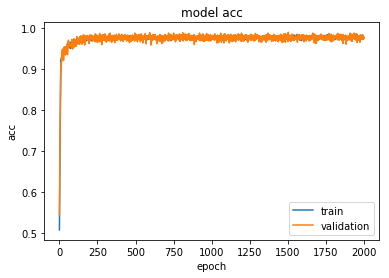

In [18]:
if(EXECUTION_MODE == "train"):

    history = bidirectional_ave_model.fit_generator(
        batch_for_network_generator(),
        steps_per_epoch=BATCH_SIZE,
        validation_data=batch_for_network_generator(),
        validation_steps=BATCH_SIZE/4,
        epochs=EPOCH_SIZE,
        callbacks=callbacks_list
    )

    list_of_histories.append(history)

    plot_train(list_of_histories)

# BATCH_SIZE = 64
# PALINDROME_SIZE = 10
# NUM_OF_CHARS = 26
# PATIENCE = 50

# 1 x Bidirectional(LSTM(16), "ave") - val_acc at 0.9961 after 169 epochs, peak val_acc at 0.9990 after 118 epochs
# 1 x Bidirectional(LSTM(16), "ave") - val_acc at 0.9980 after 234 epochs, peak val_acc at 1.0000 after 183 epochs
# 1 x Bidirectional(LSTM(16), "ave") - val_acc at 0.9971 after 327 epochs, peak val_acc at 1.0000 after 276 epochs
# 1 x Bidirectional(LSTM(16), "ave") - val_acc at 0.9971 after 391 epochs, peak val_acc at 1.0000 after 340 epochs

# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9971 after 173 epochs, peak val_acc at 0.9971 after 122 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9922 after 291 epochs, peak val_acc at 0.9990 after 240 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9961 after 389 epochs, peak val_acc at 1.0000 after 338 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9961 after 450 epochs, peak val_acc at 0.9980 after 399 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9932 after 504 epochs, peak val_acc at 0.9990 after 403 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9932 after 607 epochs, peak val_acc at 1.0000 after 556 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9922 after 715 epochs, peak val_acc at 0.9990 after 664 epochs
# 1 x Bidirectional(LSTM(8), "ave") - val_acc at 0.9941 after 770 epochs, peak val_acc at 0.9990 after 719 epochs

# 1 x Bidirectional(LSTM(4), "ave") - val_acc at 0.9648 after 129 epochs, peak val_acc at 0.9736 after 78 epochs
# 1 x Bidirectional(LSTM(4), "ave") - val_acc at 0.9609 after 301 epochs, peak val_acc at 0.9795 after 250 epochs
# 1 x Bidirectional(LSTM(4), "ave") - val_acc at 0.9668 after 413 epochs, peak val_acc at 0.9775 after 362 epochs
# 1 x Bidirectional(LSTM(4), "ave") - val_acc at 0.9648 after 503 epochs, peak val_acc at 0.9795 after 452 epochs
# 1 x Bidirectional(LSTM(4), "ave") - val_acc at 0.9727 after 609 epochs, peak val_acc at 0.9785 after 558 epochs
# 1 x Bidirectional(LSTM(4), "ave") - val_acc at 0.9629 after 695 epochs, peak val_acc at 0.9785 after 644 epochs

# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8301 after 138 epochs, peak val_acc at 0.9082 after 87 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8564 after 194 epochs, peak val_acc at 0.8652 after 143 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8516 after 316 epochs, peak val_acc at 0.8672 after 265 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8369 after 365 epochs, peak val_acc at 0.8643 after 314 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8281 after 430 epochs, peak val_acc at 0.8740 after 379 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8369 after 608 epochs, peak val_acc at 0.8809 after 557 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8574 after 662 epochs, peak val_acc at 0.8643 after 611 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8359 after 757 epochs, peak val_acc at 0.8701 after 706 epochs
# 1 x Bidirectional(LSTM(2), "ave") - val_acc at 0.8350 after 811 epochs, peak val_acc at 0.8760 after 760 epochs

# 1 x Bidirectional(LSTM(1), "ave") - val_acc at 0.8623 after 102 epochs, peak val_acc at 0.8936 after 51 epochs
# 1 x Bidirectional(LSTM(1), "ave") - val_acc at 0.8721 after 197 epochs, peak val_acc at 0.8984 after 146 epochs
# 1 x Bidirectional(LSTM(1), "ave") - val_acc at 0.8857 after 252 epochs, peak val_acc at 0.8857 after 201 epochs
# 1 x Bidirectional(LSTM(1), "ave") - val_acc at 0.8594 after 384 epochs, peak val_acc at 0.8896 after 333 epochs
# 1 x Bidirectional(LSTM(1), "ave") - val_acc at 0.8662 after 447 epochs, peak val_acc at 0.8896 after 396 epochs
# 1 x Bidirectional(LSTM(1), "ave") - val_acc at 0.8633 after 535 epochs, peak val_acc at 0.8896 after 484 epochs

In [40]:
filepath = "Palindrome-LSTM_bidirectional_ave_%s.h5" % FILE_SUFFIX
if(EXECUTION_MODE == "train"):
    bidirectional_ave_model.save(filepath)
elif(EXECUTION_MODE == "load_pretrained"):
    bidirectional_ave_model = load_model(filepath)
    print("Model is loaded from a pretrained model")
    bidirectional_ave_model.summary()
    
predict_with_model(bidirectional_ave_model, batch_for_network_generator)

Model is loaded from a pretrained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 4)                 992       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 997
Trainable params: 997
Non-trainable params: 0
_________________________________________________________________
Predicted correctly: 97.69345238095238 %
Out of the wrongs, percentage of false positives: 96.7741935483871 %
Out of the wrongs, percentage of false negatives: 3.225806451612903 %
Wrongs
['Test', 'Actual', 'Predicted']
[['jnijlnxjhp' '0' '1']
 ['ayjoaasvyv' '0' '1']
 ['vgsffsfevn' '0' '1']
 ['hwqaaihusg' '0' '1']
 ['nkhveeeskp' '0' '1']
 ['ymanpgiwot' '0' '1']
 ['mi

# Invert Target

In [ ]:
def batch_for_network_inverter():
    while True:
        X, Y = next(batch_for_network_generator())
        Y ^= 1
        yield X, Y
        
# next(batch_for_network_inverter())

# LSTM Bidirectional-Concat Model - Inverted, with "0" as palindrome

In [21]:
if(EXECUTION_MODE == "train"):
    
    inp = Input(shape=(PALINDROME_SIZE, NUM_OF_CHARS))
    print('our input shape is ',(PALINDROME_SIZE, NUM_OF_CHARS) )
    x = Bidirectional( LSTM(4) , input_shape=(PALINDROME_SIZE, 1),  merge_mode='concat' )(inp)
#     x = Dropout(0.2)(x)  # Dropout is commented to remove randomness for better comparison
    output = Dense(1, activation ='sigmoid')(x)
    
    adam = Adam(lr=0.01)
    bidirectional_concat_inverted_model = Model(inputs = inp, outputs=output )
    bidirectional_concat_inverted_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    bidirectional_concat_inverted_model.summary()
    
    list_of_histories = []

our input shape is  (10, 26)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 8)                 992       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
64/64 [==============================] - 3s - loss: 0.6945 - acc: 0.5120 - val_loss: 0.6955 - val_acc: 0.4854
Epoch 2/2000
64/64 [==============================] - 2s - loss: 0.6879 - acc: 0.5376 - val_loss: 0.6786 - val_acc: 0.5938
Epoch 3/2000
64/64 [==============================] - 2s - loss: 0.6640 - acc: 0.6021 - val_loss: 0.6358 - val_acc: 0.6406
Epoch 4/2000
64/64 [==============================] - 2s - loss: 0.6247 - acc: 0.6494 - val_loss: 0.5762 - val_acc: 0.7119
Epoch 5/2000
64/64 [==============================] - 2s - loss: 0.5500 - acc: 0.7307 - val_loss: 0.4998 - val_acc: 0.7695
Epoch 6/2000
64/64 [==============================] - 2s - loss: 0.4669 - acc: 0.7957 - val_loss: 0.4275 - val_acc: 0.8242
Epoch 7/2000
64/64 [==============================] - 2s - loss: 0.4360 - acc: 0.8137 - val_loss: 0.4822 - val_acc: 0.7666
Epoch 8/2000
64/64 [==============================] - 2s - loss: 0.3871 - acc: 0.8455 - val_loss: 0.3599 - val_acc: 0.8662
Epoch 9/2000
64/

64/64 [==============================] - 2s - loss: 0.1412 - acc: 0.9546 - val_loss: 0.1363 - val_acc: 0.9482
Epoch 131/2000
64/64 [==============================] - 2s - loss: 0.1521 - acc: 0.9492 - val_loss: 0.1500 - val_acc: 0.9541
Epoch 132/2000
64/64 [==============================] - 2s - loss: 0.1392 - acc: 0.9556 - val_loss: 0.1240 - val_acc: 0.9648
Epoch 133/2000
64/64 [==============================] - 2s - loss: 0.1334 - acc: 0.9585 - val_loss: 0.1187 - val_acc: 0.9629
Epoch 134/2000
64/64 [==============================] - 2s - loss: 0.1359 - acc: 0.9578 - val_loss: 0.1394 - val_acc: 0.9531
Epoch 135/2000
64/64 [==============================] - 2s - loss: 0.1365 - acc: 0.9570 - val_loss: 0.1234 - val_acc: 0.9639
Epoch 136/2000
64/64 [==============================] - 2s - loss: 0.1246 - acc: 0.9626 - val_loss: 0.1545 - val_acc: 0.9482
Epoch 137/2000
64/64 [==============================] - 2s - loss: 0.1308 - acc: 0.9592 - val_loss: 0.1427 - val_acc: 0.9502
Epoch 138/2000


64/64 [==============================] - 2s - loss: 0.1109 - acc: 0.9673 - val_loss: 0.1081 - val_acc: 0.9648
Epoch 261/2000
64/64 [==============================] - 2s - loss: 0.1143 - acc: 0.9636 - val_loss: 0.1214 - val_acc: 0.9580
Epoch 262/2000
64/64 [==============================] - 2s - loss: 0.1088 - acc: 0.9658 - val_loss: 0.1528 - val_acc: 0.9482
Epoch 263/2000
64/64 [==============================] - 2s - loss: 0.1157 - acc: 0.9648 - val_loss: 0.1177 - val_acc: 0.9639
Epoch 264/2000
64/64 [==============================] - 2s - loss: 0.1179 - acc: 0.9641 - val_loss: 0.1217 - val_acc: 0.9590
Epoch 265/2000
64/64 [==============================] - 2s - loss: 0.1128 - acc: 0.9666 - val_loss: 0.0970 - val_acc: 0.9707
Epoch 266/2000
64/64 [==============================] - 2s - loss: 0.1051 - acc: 0.9683 - val_loss: 0.1055 - val_acc: 0.9727
Epoch 267/2000
64/64 [==============================] - 2s - loss: 0.1207 - acc: 0.9631 - val_loss: 0.1107 - val_acc: 0.9717
Epoch 268/2000


64/64 [==============================] - 2s - loss: 0.1160 - acc: 0.9656 - val_loss: 0.1010 - val_acc: 0.9688
Epoch 391/2000
64/64 [==============================] - 2s - loss: 0.1258 - acc: 0.9614 - val_loss: 0.0896 - val_acc: 0.9766
Epoch 392/2000
64/64 [==============================] - 2s - loss: 0.1251 - acc: 0.9629 - val_loss: 0.1034 - val_acc: 0.9688
Epoch 393/2000
64/64 [==============================] - 2s - loss: 0.1208 - acc: 0.9641 - val_loss: 0.1078 - val_acc: 0.9678
Epoch 394/2000
64/64 [==============================] - 2s - loss: 0.1064 - acc: 0.9714 - val_loss: 0.1194 - val_acc: 0.9707
Epoch 395/2000
64/64 [==============================] - 2s - loss: 0.1017 - acc: 0.9690 - val_loss: 0.1256 - val_acc: 0.9619
Epoch 396/2000
64/64 [==============================] - 2s - loss: 0.1077 - acc: 0.9680 - val_loss: 0.1122 - val_acc: 0.9658
Epoch 397/2000
64/64 [==============================] - 2s - loss: 0.1029 - acc: 0.9707 - val_loss: 0.1093 - val_acc: 0.9668
Epoch 398/2000


64/64 [==============================] - 2s - loss: 0.1074 - acc: 0.9683 - val_loss: 0.1121 - val_acc: 0.9648
Epoch 519/2000
64/64 [==============================] - 2s - loss: 0.1018 - acc: 0.9692 - val_loss: 0.1280 - val_acc: 0.9600
Epoch 520/2000
64/64 [==============================] - 2s - loss: 0.1205 - acc: 0.9629 - val_loss: 0.1189 - val_acc: 0.9639
Epoch 521/2000
64/64 [==============================] - 2s - loss: 0.1056 - acc: 0.9688 - val_loss: 0.1403 - val_acc: 0.95310.96
Epoch 522/2000
64/64 [==============================] - 2s - loss: 0.1163 - acc: 0.9634 - val_loss: 0.1046 - val_acc: 0.9707
Epoch 523/2000
64/64 [==============================] - 2s - loss: 0.1098 - acc: 0.9680 - val_loss: 0.1057 - val_acc: 0.9658
Epoch 524/2000
64/64 [==============================] - 2s - loss: 0.1032 - acc: 0.9692 - val_loss: 0.1191 - val_acc: 0.9658
Epoch 525/2000
64/64 [==============================] - 2s - loss: 0.1180 - acc: 0.9622 - val_loss: 0.1207 - val_acc: 0.9619
Epoch 526/2

64/64 [==============================] - 2s - loss: 0.1095 - acc: 0.9678 - val_loss: 0.1032 - val_acc: 0.9688
Epoch 648/2000
64/64 [==============================] - 2s - loss: 0.1133 - acc: 0.9666 - val_loss: 0.1022 - val_acc: 0.9648
Epoch 649/2000
64/64 [==============================] - 2s - loss: 0.1070 - acc: 0.9688 - val_loss: 0.1113 - val_acc: 0.9678
Epoch 650/2000
64/64 [==============================] - 2s - loss: 0.1033 - acc: 0.9697 - val_loss: 0.1157 - val_acc: 0.9668
Epoch 651/2000
64/64 [==============================] - 2s - loss: 0.1156 - acc: 0.9666 - val_loss: 0.1098 - val_acc: 0.9688
Epoch 652/2000
64/64 [==============================] - 2s - loss: 0.1171 - acc: 0.9636 - val_loss: 0.1100 - val_acc: 0.9727
Epoch 653/2000
64/64 [==============================] - 2s - loss: 0.1142 - acc: 0.9668 - val_loss: 0.0971 - val_acc: 0.9707
Epoch 654/2000
64/64 [==============================] - 2s - loss: 0.1170 - acc: 0.9626 - val_loss: 0.1224 - val_acc: 0.9639
Epoch 655/2000


64/64 [==============================] - 2s - loss: 0.1149 - acc: 0.9629 - val_loss: 0.1097 - val_acc: 0.9648
Epoch 778/2000
64/64 [==============================] - 2s - loss: 0.1079 - acc: 0.9690 - val_loss: 0.0936 - val_acc: 0.9746
Epoch 779/2000
64/64 [==============================] - 2s - loss: 0.1083 - acc: 0.9670 - val_loss: 0.0911 - val_acc: 0.9756
Epoch 780/2000
64/64 [==============================] - 2s - loss: 0.1046 - acc: 0.9692 - val_loss: 0.1019 - val_acc: 0.9697
Epoch 781/2000
64/64 [==============================] - 2s - loss: 0.1075 - acc: 0.9661 - val_loss: 0.0955 - val_acc: 0.9756
Epoch 782/2000
64/64 [==============================] - 2s - loss: 0.1064 - acc: 0.9688 - val_loss: 0.0963 - val_acc: 0.9746
Epoch 783/2000
64/64 [==============================] - 2s - loss: 0.1011 - acc: 0.9695 - val_loss: 0.1120 - val_acc: 0.9629
Epoch 784/2000
64/64 [==============================] - 2s - loss: 0.1141 - acc: 0.9666 - val_loss: 0.1115 - val_acc: 0.9600
Epoch 785/2000


64/64 [==============================] - 2s - loss: 0.1093 - acc: 0.9700 - val_loss: 0.1161 - val_acc: 0.9619
Epoch 907/2000
64/64 [==============================] - 2s - loss: 0.1080 - acc: 0.9688 - val_loss: 0.1170 - val_acc: 0.9619
Epoch 908/2000
64/64 [==============================] - 2s - loss: 0.1034 - acc: 0.9697 - val_loss: 0.1147 - val_acc: 0.9590
Epoch 909/2000
64/64 [==============================] - 2s - loss: 0.1133 - acc: 0.9636 - val_loss: 0.1141 - val_acc: 0.9688
Epoch 910/2000
64/64 [==============================] - 2s - loss: 0.1166 - acc: 0.9639 - val_loss: 0.0797 - val_acc: 0.9766
Epoch 911/2000
64/64 [==============================] - 2s - loss: 0.1208 - acc: 0.9636 - val_loss: 0.0961 - val_acc: 0.9746
Epoch 912/2000
64/64 [==============================] - 2s - loss: 0.1127 - acc: 0.9668 - val_loss: 0.0985 - val_acc: 0.9727
Epoch 913/2000
64/64 [==============================] - 2s - loss: 0.1058 - acc: 0.9685 - val_loss: 0.1118 - val_acc: 0.9629
Epoch 914/2000


64/64 [==============================] - 2s - loss: 0.1099 - acc: 0.9678 - val_loss: 0.1087 - val_acc: 0.9697
Epoch 1037/2000
64/64 [==============================] - 2s - loss: 0.1048 - acc: 0.9712 - val_loss: 0.1259 - val_acc: 0.9580
Epoch 1038/2000
64/64 [==============================] - 2s - loss: 0.1029 - acc: 0.9709 - val_loss: 0.1149 - val_acc: 0.9609
Epoch 1039/2000
64/64 [==============================] - 2s - loss: 0.1110 - acc: 0.9673 - val_loss: 0.1132 - val_acc: 0.9648
Epoch 1040/2000
64/64 [==============================] - 2s - loss: 0.1154 - acc: 0.9656 - val_loss: 0.1256 - val_acc: 0.9600
Epoch 1041/2000
64/64 [==============================] - 2s - loss: 0.1105 - acc: 0.9690 - val_loss: 0.1019 - val_acc: 0.9736
Epoch 1042/2000
64/64 [==============================] - 2s - loss: 0.1053 - acc: 0.9697 - val_loss: 0.0920 - val_acc: 0.9756
Epoch 1043/2000
64/64 [==============================] - 2s - loss: 0.1093 - acc: 0.9668 - val_loss: 0.1172 - val_acc: 0.9619
Epoch 10

64/64 [==============================] - 2s - loss: 0.1087 - acc: 0.9675 - val_loss: 0.1083 - val_acc: 0.9648
Epoch 1166/2000
64/64 [==============================] - 2s - loss: 0.1164 - acc: 0.9636 - val_loss: 0.1156 - val_acc: 0.96580
Epoch 1167/2000
64/64 [==============================] - 2s - loss: 0.1212 - acc: 0.9634 - val_loss: 0.0991 - val_acc: 0.9756
Epoch 1168/2000
64/64 [==============================] - 2s - loss: 0.1103 - acc: 0.9651 - val_loss: 0.1176 - val_acc: 0.9678
Epoch 1169/2000
64/64 [==============================] - 2s - loss: 0.1103 - acc: 0.9651 - val_loss: 0.0949 - val_acc: 0.9775
Epoch 1170/2000
64/64 [==============================] - 2s - loss: 0.1083 - acc: 0.9666 - val_loss: 0.1131 - val_acc: 0.9678
Epoch 1171/2000
64/64 [==============================] - 2s - loss: 0.1080 - acc: 0.9648 - val_loss: 0.1282 - val_acc: 0.9639
Epoch 1172/2000
64/64 [==============================] - 2s - loss: 0.0974 - acc: 0.9709 - val_loss: 0.1130 - val_acc: 0.9639
Epoch 1

64/64 [==============================] - 2s - loss: 0.0973 - acc: 0.9731 - val_loss: 0.1241 - val_acc: 0.9580
Epoch 1294/2000
64/64 [==============================] - 2s - loss: 0.1067 - acc: 0.9658 - val_loss: 0.1271 - val_acc: 0.9629
Epoch 1295/2000
64/64 [==============================] - 2s - loss: 0.1118 - acc: 0.9668 - val_loss: 0.1113 - val_acc: 0.9668
Epoch 1296/2000
64/64 [==============================] - 2s - loss: 0.1041 - acc: 0.9695 - val_loss: 0.1002 - val_acc: 0.97170.9
Epoch 1297/2000
64/64 [==============================] - 2s - loss: 0.0965 - acc: 0.9741 - val_loss: 0.0977 - val_acc: 0.9688
Epoch 1298/2000
64/64 [==============================] - 2s - loss: 0.1050 - acc: 0.9680 - val_loss: 0.1167 - val_acc: 0.9678
Epoch 1299/2000
64/64 [==============================] - 2s - loss: 0.1065 - acc: 0.9675 - val_loss: 0.1251 - val_acc: 0.9619
Epoch 1300/2000
64/64 [==============================] - 2s - loss: 0.1117 - acc: 0.9688 - val_loss: 0.1158 - val_acc: 0.9600
Epoch

64/64 [==============================] - 2s - loss: 0.1030 - acc: 0.9707 - val_loss: 0.1056 - val_acc: 0.9668
Epoch 1359/2000
64/64 [==============================] - 2s - loss: 0.1124 - acc: 0.9646 - val_loss: 0.1026 - val_acc: 0.9727
Epoch 1360/2000
64/64 [==============================] - 2s - loss: 0.1058 - acc: 0.9678 - val_loss: 0.1189 - val_acc: 0.9619
Epoch 1361/2000
64/64 [==============================] - 2s - loss: 0.1006 - acc: 0.9683 - val_loss: 0.0907 - val_acc: 0.9736
Epoch 1362/2000
64/64 [==============================] - 2s - loss: 0.1041 - acc: 0.9688 - val_loss: 0.1149 - val_acc: 0.9629
Epoch 1363/2000
64/64 [==============================] - 2s - loss: 0.1019 - acc: 0.9692 - val_loss: 0.1154 - val_acc: 0.9629
Epoch 1364/2000
64/64 [==============================] - 2s - loss: 0.1026 - acc: 0.9688 - val_loss: 0.1153 - val_acc: 0.9678
Epoch 1365/2000
64/64 [==============================] - 2s - loss: 0.1144 - acc: 0.9653 - val_loss: 0.1080 - val_acc: 0.9688
Epoch 13

64/64 [==============================] - 2s - loss: 0.1147 - acc: 0.9639 - val_loss: 0.1165 - val_acc: 0.9639
Epoch 1488/2000
64/64 [==============================] - 2s - loss: 0.1119 - acc: 0.9648 - val_loss: 0.1158 - val_acc: 0.9648
Epoch 1489/2000
64/64 [==============================] - 2s - loss: 0.1045 - acc: 0.9702 - val_loss: 0.1185 - val_acc: 0.9668
Epoch 1490/2000
64/64 [==============================] - 2s - loss: 0.1166 - acc: 0.9639 - val_loss: 0.0944 - val_acc: 0.9746
Epoch 1491/2000
64/64 [==============================] - 2s - loss: 0.1163 - acc: 0.9651 - val_loss: 0.1049 - val_acc: 0.9688
Epoch 1492/2000
64/64 [==============================] - 2s - loss: 0.1063 - acc: 0.9663 - val_loss: 0.0934 - val_acc: 0.9697
Epoch 1493/2000
64/64 [==============================] - 2s - loss: 0.1154 - acc: 0.9634 - val_loss: 0.1151 - val_acc: 0.9600
Epoch 1494/2000
64/64 [==============================] - 2s - loss: 0.0999 - acc: 0.9683 - val_loss: 0.0979 - val_acc: 0.9697
Epoch 14

64/64 [==============================] - 2s - loss: 0.1059 - acc: 0.9685 - val_loss: 0.1137 - val_acc: 0.9658
Epoch 1617/2000
64/64 [==============================] - 2s - loss: 0.1129 - acc: 0.9648 - val_loss: 0.0998 - val_acc: 0.9678
Epoch 1618/2000
64/64 [==============================] - 2s - loss: 0.1023 - acc: 0.9688 - val_loss: 0.1166 - val_acc: 0.9619
Epoch 1619/2000
64/64 [==============================] - 2s - loss: 0.1094 - acc: 0.9683 - val_loss: 0.1208 - val_acc: 0.9639
Epoch 1620/2000
64/64 [==============================] - 2s - loss: 0.1097 - acc: 0.9651 - val_loss: 0.1305 - val_acc: 0.96090.965
Epoch 1621/2000
64/64 [==============================] - 2s - loss: 0.1089 - acc: 0.9666 - val_loss: 0.1250 - val_acc: 0.9590
Epoch 1622/2000
64/64 [==============================] - 2s - loss: 0.1123 - acc: 0.9658 - val_loss: 0.1058 - val_acc: 0.9688
Epoch 1623/2000
64/64 [==============================] - 2s - loss: 0.1126 - acc: 0.9656 - val_loss: 0.1272 - val_acc: 0.9600
Epo

64/64 [==============================] - 2s - loss: 0.1095 - acc: 0.9690 - val_loss: 0.0960 - val_acc: 0.9736
Epoch 1745/2000
64/64 [==============================] - 2s - loss: 0.1072 - acc: 0.9680 - val_loss: 0.1010 - val_acc: 0.9697
Epoch 1746/2000
64/64 [==============================] - 2s - loss: 0.1106 - acc: 0.9663 - val_loss: 0.1094 - val_acc: 0.9648
Epoch 1747/2000
64/64 [==============================] - 2s - loss: 0.1195 - acc: 0.9619 - val_loss: 0.1077 - val_acc: 0.9678
Epoch 1748/2000
64/64 [==============================] - 2s - loss: 0.1146 - acc: 0.9661 - val_loss: 0.1174 - val_acc: 0.9629
Epoch 1749/2000
64/64 [==============================] - 2s - loss: 0.0966 - acc: 0.9714 - val_loss: 0.1085 - val_acc: 0.9717
Epoch 1750/2000
64/64 [==============================] - 2s - loss: 0.1056 - acc: 0.9680 - val_loss: 0.1000 - val_acc: 0.96970.9 - ETA: 1s - loss: 0.1059 - acc: 0. - ETA: 1s - loss: 0
Epoch 1751/2000
64/64 [==============================] - 2s - loss: 0.1005 -

64/64 [==============================] - 2s - loss: 0.1225 - acc: 0.9619 - val_loss: 0.1046 - val_acc: 0.9697
Epoch 1873/2000
64/64 [==============================] - 2s - loss: 0.0999 - acc: 0.9688 - val_loss: 0.0935 - val_acc: 0.9717
Epoch 1874/2000
64/64 [==============================] - 2s - loss: 0.1037 - acc: 0.9692 - val_loss: 0.0986 - val_acc: 0.9766
Epoch 1875/2000
64/64 [==============================] - 2s - loss: 0.1073 - acc: 0.9695 - val_loss: 0.0981 - val_acc: 0.9736
Epoch 1876/2000
64/64 [==============================] - 2s - loss: 0.1073 - acc: 0.9658 - val_loss: 0.1158 - val_acc: 0.95900.9
Epoch 1877/2000
64/64 [==============================] - 2s - loss: 0.1025 - acc: 0.9680 - val_loss: 0.1048 - val_acc: 0.9688
Epoch 1878/2000
64/64 [==============================] - 2s - loss: 0.1074 - acc: 0.9673 - val_loss: 0.1106 - val_acc: 0.9629
Epoch 1879/2000
64/64 [==============================] - 2s - loss: 0.1171 - acc: 0.9624 - val_loss: 0.1192 - val_acc: 0.9609
Epoch

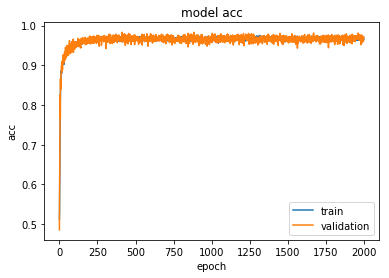

In [22]:
if(EXECUTION_MODE == "train"):

    history = bidirectional_concat_inverted_model.fit_generator(
        batch_for_network_inverter(),
        steps_per_epoch=BATCH_SIZE,
        validation_data=batch_for_network_inverter(),
        validation_steps=BATCH_SIZE/4,
        epochs=EPOCH_SIZE,
        callbacks=callbacks_list
    )

    list_of_histories.append(history)

    plot_train(list_of_histories)

# BATCH_SIZE = 64
# PALINDROME_SIZE = 10
# NUM_OF_CHARS = 26
# PATIENCE = 50

# 1 x Bi(LSTM(16), "concat"), inverted - val_acc at 0.9990 after 170 epochs, peak val_acc at 1.0000 after 119 epochs
# 1 x Bi(LSTM(16), "concat"), inverted - val_acc at 0.9980 after 225 epochs, peak val_acc at 1.0000 after 174 epochs
# 1 x Bi(LSTM(16), "concat"), inverted - val_acc at 0.9990 after 278 epochs, peak val_acc at 1.0000 after 227 epochs
# 1 x Bi(LSTM(16), "concat"), inverted - val_acc at 1.0000 after 330 epochs, peak val_acc at 1.0000 after 279 epochs
# 1 x Bi(LSTM(16), "concat"), inverted - val_acc at 0.9990 after 386 epochs, peak val_acc at 1.0000 after 335 epochs
# 1 x Bi(LSTM(16), "concat"), inverted - val_acc at 1.0000 after 438 epochs, peak val_acc at 1.0000 after 387 epochs

# 1 x Bi(LSTM(8), "concat"), inverted - val_acc at 0.9941 after 265 epochs, peak val_acc at 0.9961 after 214 epochs
# 1 x Bi(LSTM(8), "concat"), inverted - val_acc at 0.9902 after 332 epochs, peak val_acc at 0.9951 after 281 epochs
# 1 x Bi(LSTM(8), "concat"), inverted - val_acc at 0.9912 after 393 epochs, peak val_acc at 0.9941 after 342 epochs
# 1 x Bi(LSTM(8), "concat"), inverted - val_acc at 0.9902 after 488 epochs, peak val_acc at 0.9951 after 437 epochs
# 1 x Bi(LSTM(8), "concat"), inverted - val_acc at 0.9844 after 546 epochs, peak val_acc at 0.9951 after 495 epochs
# 1 x Bi(LSTM(8), "concat"), inverted - val_acc at 0.9883 after 611 epochs, peak val_acc at 0.9951 after 560 epochs

# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9629 after 152 epochs, peak val_acc at 0.9678 after 101 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9639 after 224 epochs, peak val_acc at 0.9717 after 173 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9609 after 325 epochs, peak val_acc at 0.9746 after 274 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9658 after 427 epochs, peak val_acc at 0.9795 after 376 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9619 after 526 epochs, peak val_acc at 0.9795 after 475 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9551 after 633 epochs, peak val_acc at 0.9756 after 582 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9678 after 717 epochs, peak val_acc at 0.9648 after 666 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9531 after 835 epochs, peak val_acc at 0.9775 after 784 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9668 after 890 epochs, peak val_acc at 0.9756 after 839 epochs
# 1 x Bi(LSTM(4), "concat"), inverted - val_acc at 0.9609 after 966 epochs, peak val_acc at 0.9775 after 915 epochs

# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9512 after 166 epochs, peak val_acc at 0.9619 after 115 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9463 after 233 epochs, peak val_acc at 0.9639 after 182 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9551 after 345 epochs, peak val_acc at 0.9697 after 294 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9580 after 453 epochs, peak val_acc at 0.9697 after 402 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9443 after 547 epochs, peak val_acc at 0.9678 after 496 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9590 after 641 epochs, peak val_acc at 0.9707 after 590 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9541 after 716 epochs, peak val_acc at 0.9717 after 665 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9561 after 783 epochs, peak val_acc at 0.9697 after 732 epochs
# 1 x Bi(LSTM(2), "concat"), inverted - val_acc at 0.9512 after 851 epochs, peak val_acc at 0.9707 after 800 epochs

# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8760 after 74 epochs, peak val_acc at 0.9033 after 23 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8711 after 131 epochs, peak val_acc at 0.9023 after 80 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8770 after 299 epochs, peak val_acc at 0.9102 after 248 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8867 after 374 epochs, peak val_acc at 0.9062 after 323 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8711 after 552 epochs, peak val_acc at 0.9062 after 501 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8770 after 612 epochs, peak val_acc at 0.9072 after 561 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8965 after 701 epochs, peak val_acc at 0.8955 after 650 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8740 after 779 epochs, peak val_acc at 0.9209 after 728 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8594 after 839 epochs, peak val_acc at 0.9053 after 788 epochs
# 1 x Bi(LSTM(1), "concat"), inverted - val_acc at 0.8643 after 891 epochs, peak val_acc at 0.9014 after 840 epochs

In [41]:
filepath = "Palindrome-LSTM_bidirectional_concat_inverted_%s.h5" % FILE_SUFFIX
if(EXECUTION_MODE == "train"):
    bidirectional_concat_inverted_model.save(filepath)
elif(EXECUTION_MODE == "load_pretrained"):
    bidirectional_concat_inverted_model = load_model(filepath)
    print("Model is loaded from a pretrained model")
    bidirectional_concat_inverted_model.summary()

    
predict_with_model(bidirectional_concat_inverted_model, batch_for_network_inverter)

Model is loaded from a pretrained model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 26)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 8)                 992       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Predicted correctly: 97.02380952380952 %
Out of the wrongs, percentage of false positives: 0.0 %
Out of the wrongs, percentage of false negatives: 100.0 %
Wrongs
['Test', 'Actual', 'Predicted']
[['yowjzzyekx' '1' '0']
 ['xvtbczjjtg' '1' '0']
 ['awjgikmujk' '1' '0']
 ['etjswjygby' '1' '0']
 ['cjtlmzwvwj' '1' '0']
 ['nrixhlbfln' '1' '0']
 ['owsqfrjqkd' '1' '0']
 [